# Modélisation des séries temporelles avec LSTM : Cas pratique et implémentation

# Introduction

Dans ce tutoriel destiné aux débutants, nous vous guidons pas à pas pour découvrir, analyser et modéliser des données séquentielles. Vous explorerez des approches variées, des méthodes statistiques classiques (ARIMA, SARIMA, SARIMAX) aux réseaux de neurones LSTM, en vous appuyant sur le jeu de données [Household Electric Power Consumption](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/data). L’objectif : comprendre les particularités de chaque modèle et identifier la solution la mieux adaptée à votre projet. Vous développerez ainsi des compétences précieuses en visualisation, en analyse statistique et en apprentissage automatique, et pourrez exploiter au maximum vos données temporelles.

# Exploration des Données (EDA)

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

## Chargement et exploration du dataset

In [2]:
file_path = '../data/individual+household+electric+power+consumption/household_power_consumption.txt'
if os.path.exists(file_path):
    print("File found!")
    df = pd.read_csv(file_path, sep=';', 
                     low_memory=False, 
                     na_values=['nan','?'])
    
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    df.drop(columns=['Date', 'Time'], inplace=True)
    
    print("Data loaded and datetime parsed successfully!")
else: 
    print("File NOT found, Check the path please!")

File found!
Data loaded and datetime parsed successfully!


In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
df.shape

(2075259, 7)

In [7]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

## Traitement des valeurs manquantes « nan »

In [8]:
# Vérification des Valeurs Manquantes
missing_values = df.isnull().sum()
print(missing_values)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [9]:
# Récupérer les indices des colonnes avec des valeurs manquantes
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [10]:
# Remplacer les valeurs manquantes par la moyenne de la colonne

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [11]:
#  Vérification des valeurs manquantes après le remplissage
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Description statistique du dataset

### Statistiques Deescriptives

In [12]:

df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


L’analyse statistique descriptive nous donne un aperçu des valeurs centrales, des dispersions et des extrêmes pour chaque variable du dataset Household Power Consumption.

- ***Global Active Power***

    - Moyenne (mean) : 1.09 kW → La consommation électrique moyenne est d'environ 1 kW.
    - Min & Max : 0.076 kW à 11.12 kW → La consommation varie fortement, avec des pics élevés.
    - Écart-type (std) : 1.06 kW → Forte dispersion, ce qui indique que la consommation fluctue beaucoup.
    - Distribution : La médiane (50%) est 0.6 kW, ce qui montre que la majorité des valeurs sont inférieures à la moyenne (distribution asymétrique à droite).
    - Valeurs extrêmes (outliers) : Des pics jusqu'à 11.12 kW indiquent des périodes de consommation très élevée

- ***Global Reactive Power***

    - Moyenne : 0.12 kW → Relativement faible, ce qui est normal car la puissance réactive est l’énergie non consommée (pertes).
    - Écart-type : 0.11 kW → Variation significative, bien que les valeurs restent faibles.
    - Max : 1.39 kW → Certaines périodes présentent des pertes électriques importantes.

- ***Voltage***

    - Moyenne : 240.8 V, avec un écart-type de 3.2 V → La tension est stable, centrée autour de la valeur standard de 240 V.
    - Min & Max : 223.2 V à 254.1 V → Quelques fluctuations, mais dans une plage acceptable.

- ***Global Intensity***

    - Moyenne : 4.62 A, avec une médiane de 2.6 A → L’intensité consommée est généralement faible.
    - Max : 48.4 A → Certains appareils gourmands en énergie peuvent provoquer des pics.

### Visualisation des Distributions

array([[<Axes: title={'center': 'Global_active_power'}>,
        <Axes: title={'center': 'Global_reactive_power'}>,
        <Axes: title={'center': 'Voltage'}>],
       [<Axes: title={'center': 'Global_intensity'}>,
        <Axes: title={'center': 'Sub_metering_1'}>,
        <Axes: title={'center': 'Sub_metering_2'}>],
       [<Axes: title={'center': 'Sub_metering_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

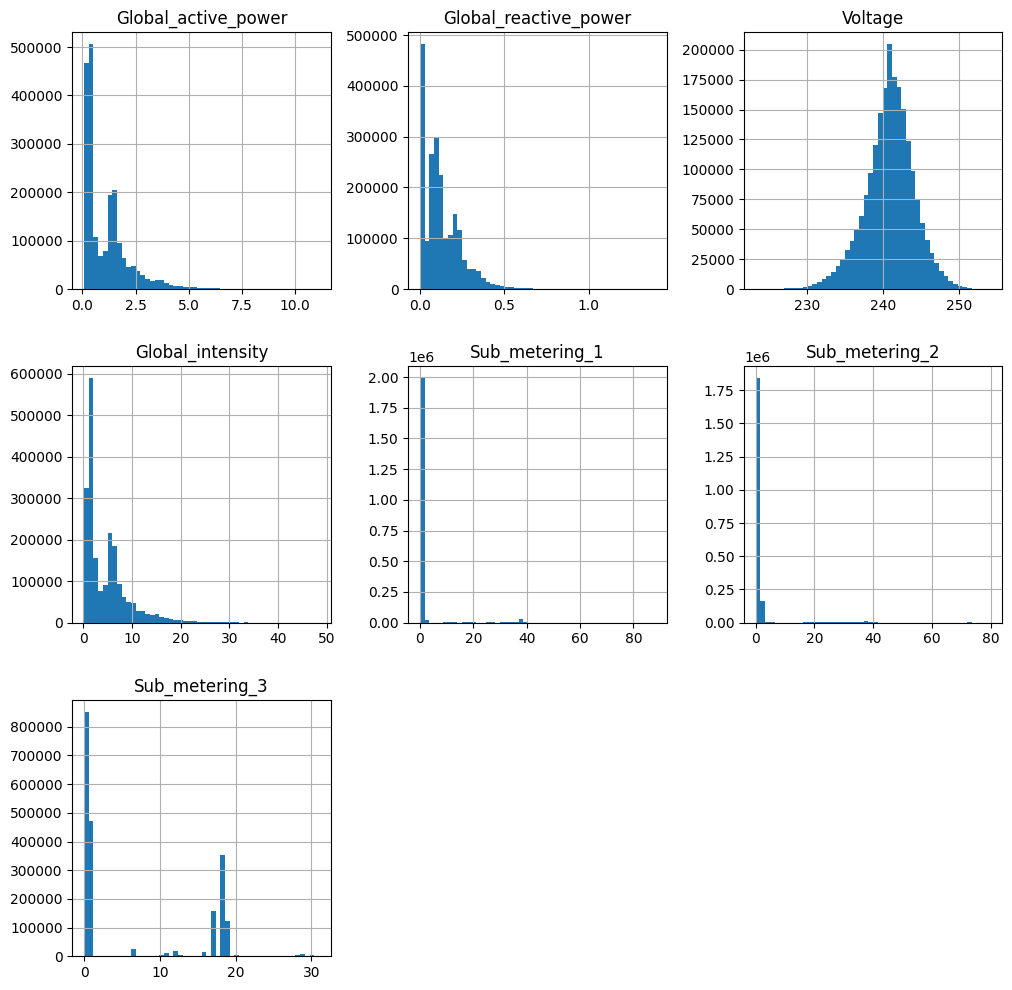

In [13]:

df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].hist(bins=50, figsize=(12, 12))

Le graph ci-dessus permet d'examiner la distribution des différentes variables du dataset Household Power Consumption.

- ***Global Active Power***:
    - Fortement asymétrique à droite (right‐skewed) : la plupart des valeurs sont inférieures à 2 kW, et le maximum s’étend jusqu’à environ 10–11 kW.

    - On aperçoit en effet deux zones de densité plus importantes (l’une autour de 0,5 kW et l’autre près de 1,5 kW), ce qui peut indiquer plusieurs modes de fonctionnement

- ***Voltage*** :
    - Distribué autour de 240 V avec des valeurs comprises entre environ 223 V et 254 V, et une forme assez proche d’une gaussienne.
    - Le centre (moyenne à 240,8 V) et la relative symétrie du histogramme confirment une tension globalement stable.

- ***Global Intensity*** suit une distribution similaire à la puissance active globale, car elle est directement liée à la consommation électrique (puissance = tension × intensité).
    - La majorité des valeurs sont faibles (< 10 A), mais il existe quelques valeurs plus élevées allant jusqu'à 50 A.

- ***Sub_metering_1 et Sub_metering_2*** : On obseve que la majorité des valeurs sont proches de 0, indiquant que cette sous-mesure ne capture de l’énergie que dans certaines périodes spécifiques.

- ***Sub_metering_3***:  On observe trois pics distincts ce qui peut être lié à des variations de consommation en fonction des saisons.


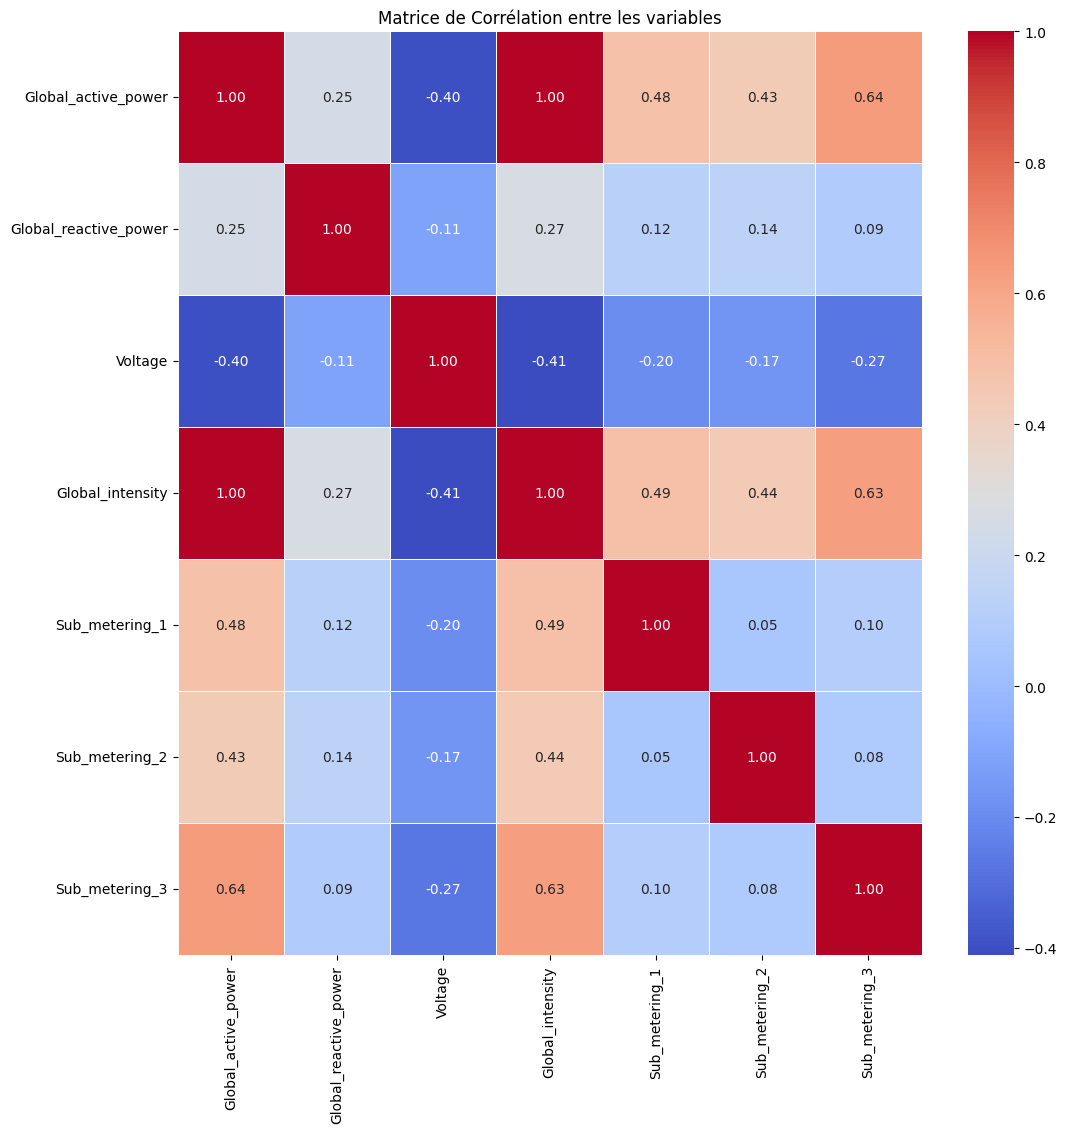

In [14]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation entre les variables")
plt.show()


Ce heatmap de corrélation permet de visualiser les relations entre les variables du dataset. Cette matrice nous aide à identifier les variables pertinentes pour prédire la consommation.

- ***Variables fortement corrélées***

    - Global_active_power et Global_intensity (+1.00): l'intensité électrique est directement liée à la puissance consommée.
    - Global_active_power et Sub_metering_3 (+0.64): la consommation mesurée par le compteur 3 contribue fortement à la consommation totale.
    - Global_intensity et Sub_metering_3 (+0.63): Une hausse de l'intensité est souvent associée à une augmentation de la consommation de ce compteur.

- ***Variables avec une corrélation négative***

    - Voltage et Global_active_power (-0.40) : lorsque la puissance consommée augmente, la tension a tendance à baisser.
    - Voltage et Global_intensity (-0.41): plus l’intensité augmente, plus la tension baisse, ce qui peut être dû à une chute de tension provoquée par une forte demande.

- ***Variables faiblement corrélées***
    - Global_reactive_power a une faible corrélation avec la puissance active (0.25).
    - L'heure (hour) n'a qu'une légère influence sur la consommation (0.28 avec Global_active_power).
    - Les Sub_metering 1 & 2 sont peu corrélés aux autres variables, suggérant qu’ils mesurent des équipements spécifiques.
    
La tension et l’intensité influencent directement la puissance consommée.
Les sous-compteurs ont un impact inégal, suggérant des usages différents.


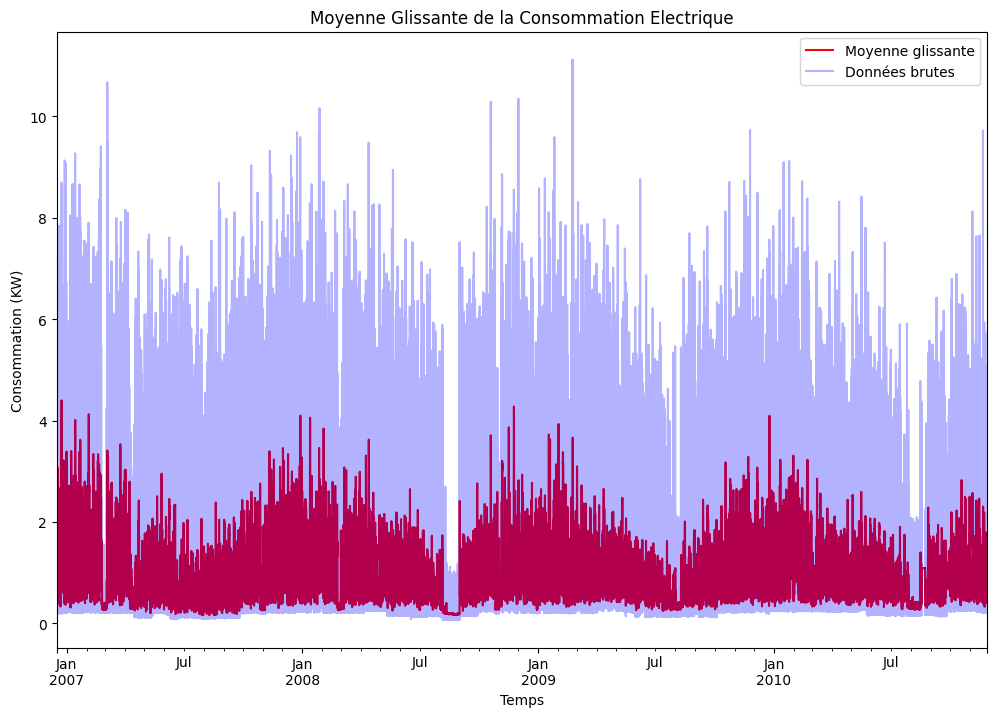

In [15]:
plt.figure(figsize=(12, 8))
df['Global_active_power'].rolling(window=500).mean().plot(label='Moyenne glissante', color='red')
df['Global_active_power'].plot(alpha=0.3, label="Données brutes", color='blue')

plt.legend()
plt.title("Moyenne Glissante de la Consommation Electrique")
plt.xlabel("Temps")
plt.ylabel("Consommation (KW)")
plt.show()


Nous essayons d'analyser les tendances de consommation électrique au fil du temps en utilisant une moyenne glissante.

- ***Données brutes (en bleu clair)***:

    - La série temporelle montre une forte variabilité avec des pics fréquents.
    -Plusieurs cycles de hausse et de baisse se distinguent, suggérant une composante saisonnière ou des variations récurrentes (journalières, hebdomadaires, saisonnières…).

- ***Moyenne glissante (en rouge foncé)***:

    - Elle met en évidence une tendance générale légèrement croissante sur la période couverte par le graphique.
    - On remarque une tendance à la hausse et des variations cycliques
    - La consommation semble légèrement plus élevée en hiver.


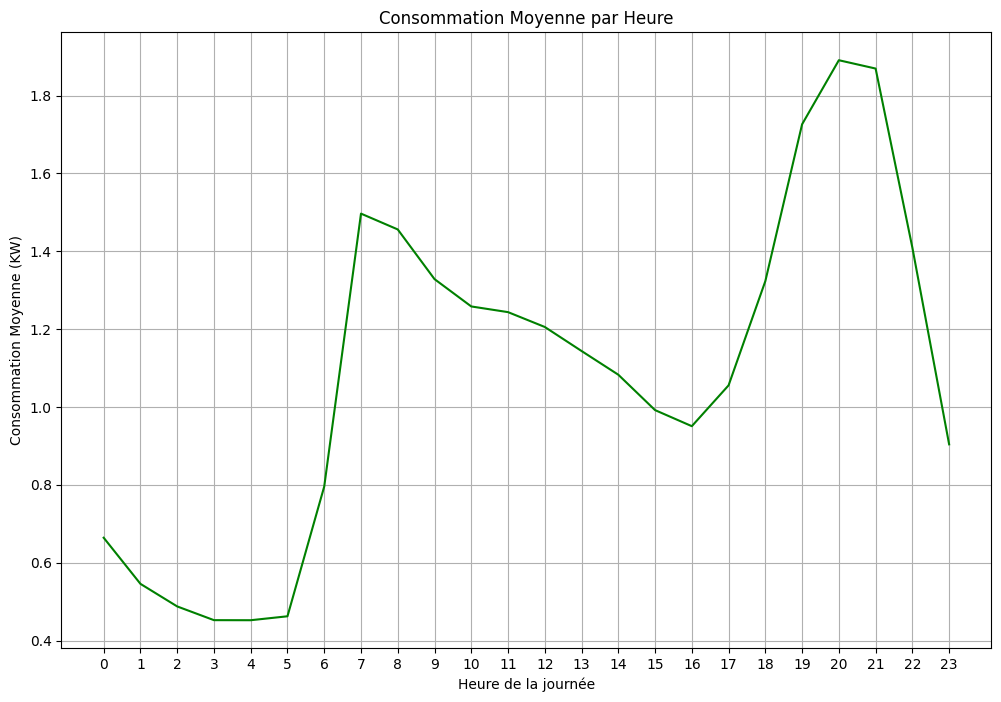

In [16]:
# Saisonnière - Moyenne par Heure
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, markers='o', color='green')
plt.title("Consommation Moyenne par Heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Consommation Moyenne (KW)")
plt.xticks(range(0, 24))
plt.grid()
plt.show()


Ce graphique montre la moyenne de la consommation électrique en fonction de l’heure de la journée.

- ***Baisse pendant la nuit (0 h – 5 h)***:

    La consommation passe en dessous de 0,5–0,6 kW, ce qui est cohérent avec un usage restreint d’appareils électriques pendant le sommeil.

- ***Pic matinal (6 h – 8 h)*** :

    La montée rapide jusqu’à 1,5 kW (voire plus) autour de 7 h – 8 h est assez classique : préparation du petit déjeuner, éclairage, chauffage

- ***Stabilisation en journée (10h - 16h)*** :

    Le niveau autour de 0,9–1 kW peut s’expliquer par des usages modérés (peu d’appareils simultanés) ou par des équipements en veille

- ***Pic en soirée (18 h – 21 h)*** :
   La remontée notable jusqu’à environ 1,9 kW correspond bien à la fin de journée : retour au domicile, préparation du dîner, utilisation combinée de luminaires, d’appareils de cuisson, télévision

- ***Baisse après 22 h*** :

    Une fois les activités du soir terminées, la consommation redescend, anticipant à nouveau la période de nuit.


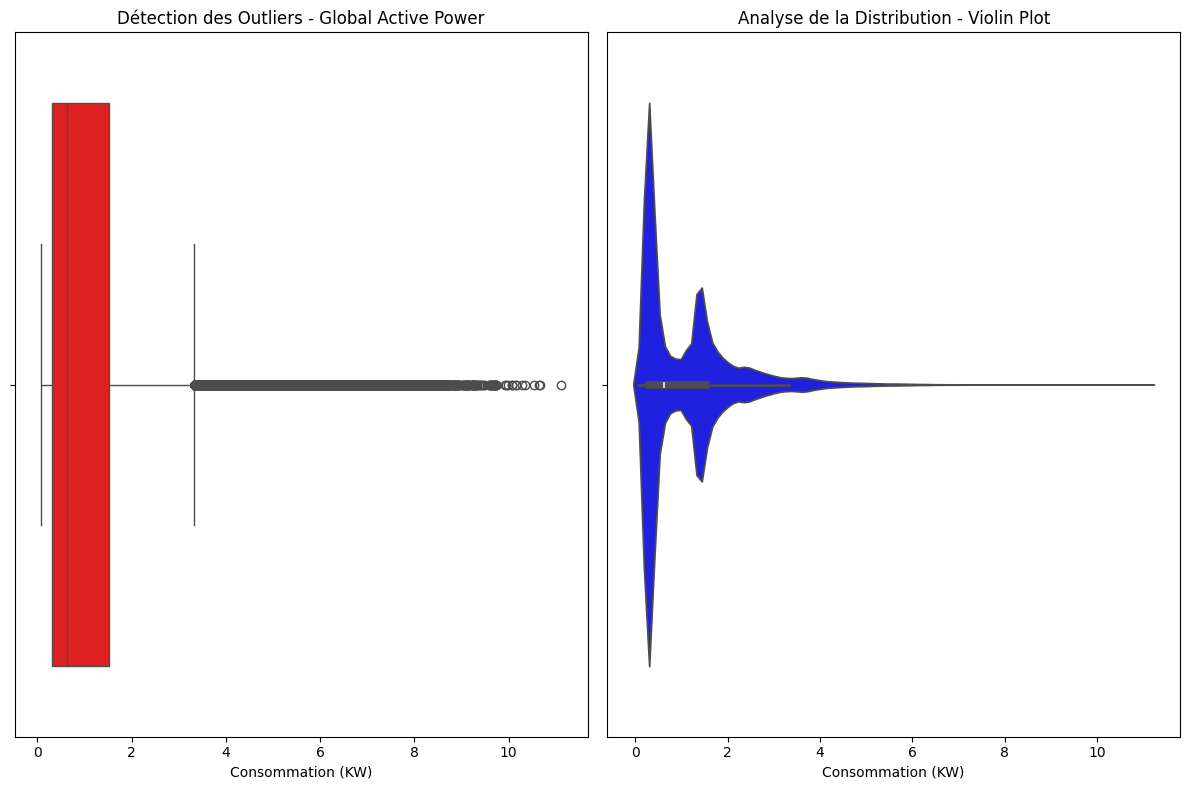

In [17]:

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# Boxplot pour la détection des outliers
sns.boxplot(x=df['Global_active_power'], color='red', ax=axes[0])
axes[0].set_title("Détection des Outliers - Global Active Power")
axes[0].set_xlabel("Consommation (KW)")

# Violin Plot pour l'analyse de la distribution
sns.violinplot(x=df['Global_active_power'], color='blue', ax=axes[1])
axes[1].set_title("Analyse de la Distribution - Violin Plot")
axes[1].set_xlabel("Consommation (KW)")

plt.tight_layout()
plt.show()


Le graphique ci-dessus affiche à gauche un boxplot et à droite un violin plot pour analyser la distribution et détecter les valeurs aberrantes de la consommation électrique (Global Active Power).

- ***Boxplot (Gauche)***

    - Le rectangle rouge représente l’intervalle interquartile (IQR), qui couvre 50% des valeurs.
    - La ligne centrale indique la médiane, et les "moustaches" étendent les données jusqu'à 1.5 fois l'IQR.
    - Les points au-delà des moustaches sont considérés comme des outliers (valeurs extrêmes).
    - Il semble y avoir de nombreuses valeurs extrêmes au-dessus du maximum attendu.

- ***Violin Plot (Droite)***

    - Il montre une version lissée de l’histogramme pour visualiser la densité des valeurs.
    On remarque une concentration des données autour des faibles valeurs de consommation entre 0 et 2 kW.
    Une forte densité autour de 1 kW, ce qui signifie que cette consommation est courante
  
Contrairement au boxplot, le violin plot montre comment les valeurs sont réparties.

# Statistique

## Analyse statistique

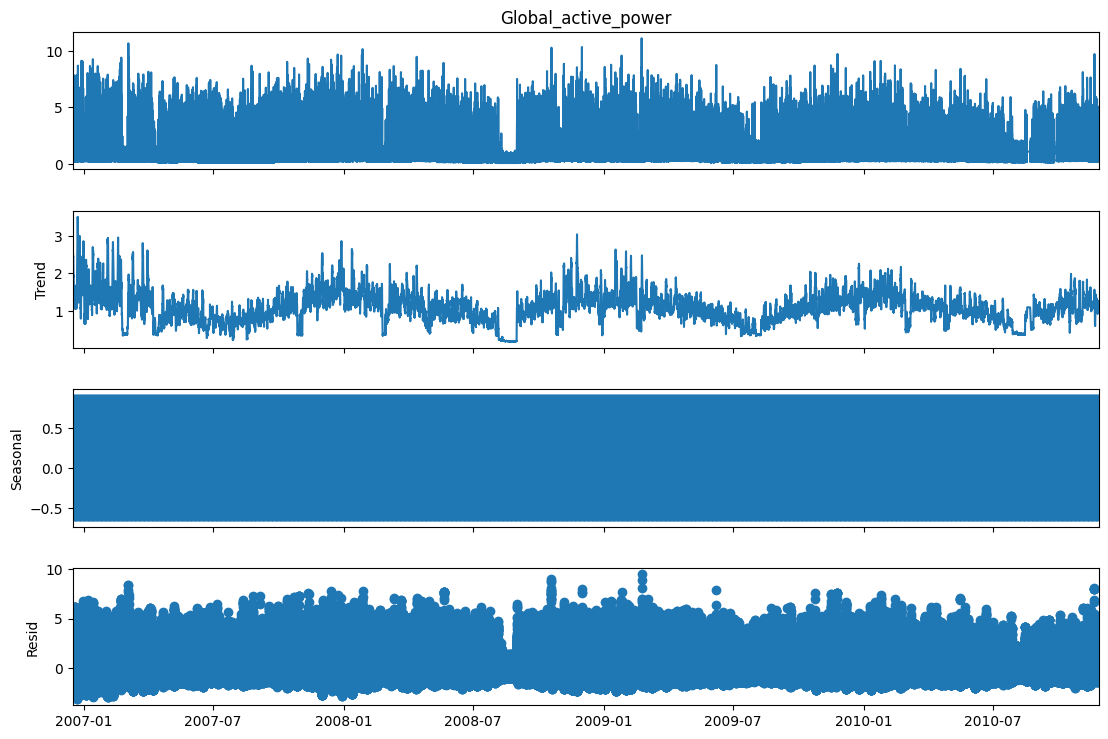

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Global_active_power'], period=1440)  # 1440 minutes = 1 jour

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()


- La tendance détecte une baisse progressive puis une relative stabilisation.

- La composante saisonnière met en avant un cycle quotidien modéré (comparé à la variabilité globale).

- Le résidu reste large, signe d’une forte fluctuation horaire.

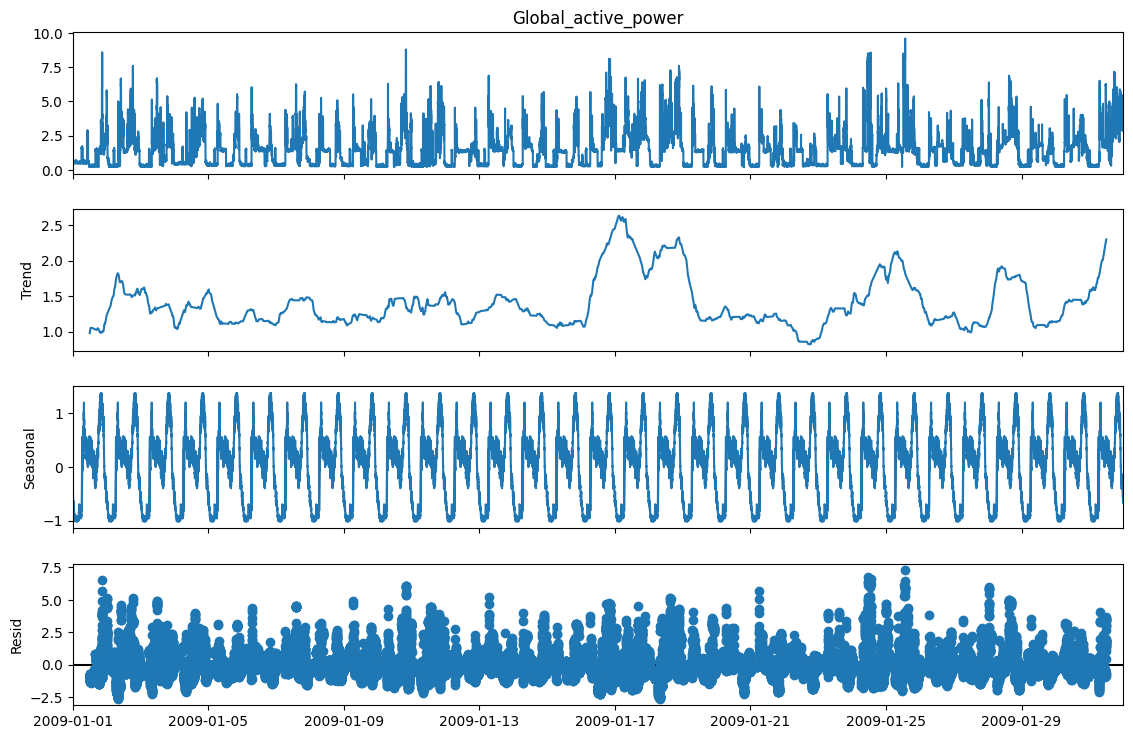

In [19]:
df_sample = df.loc['2009-01-01':'2009-01-31']
decomposition = seasonal_decompose(df_sample['Global_active_power'], period=1440) 
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()



Ce graphique représente la décomposition de la série temporelle pour la consommation électrique (Global_active_power) sur un mois complet en janvier 2009.

- ***Série Originale (Global_active_power)***

    - On observe d’importantes variations de la consommation électrique.

    - Les pics sont réguliers, souvent associés aux moments de forte activité dans la journée (matin et soir).

    - On remarque aussi des périodes de consommation très faible, probablement la nuit.

- ***Tendance (Trend)***

    - La tendance générale montre une évolution progressive de la consommation.

    Il y a une hausse autour du 15 janvier et une diminution est visible autour du 19 janvier.

- ***Saisonnalité (Seasonal)***

    - La saisonnalité est bien marquée avec un cycle de 24 heures.

    - Cela correspond aux habitudes quotidiennes des utilisateurs : forte consommation le matin et le soir.

    - Ce comportement répétitif confirme l'influence des rythmes de vie.

- ***Résidus (Resid)***
    - Ces résidus représentent la partie imprévisible de la série.

    - On observe des variations importantes, ce qui suggère des anomalies ponctuelles.
    
    - Ces pics aléatoires pourraient être causés par des événements exceptionnels (ex. équipements activés de manière irrégulière).

## Tests d'Hypothèses

- ***Test de Stationnarité Dickey-Fuller (adfuller)***
Le test de Dickey-Fuller Augmenté (ADF) vérifie si une série temporelle est stationnaire ou non stationnaire.

    - **Hypothèse nulle (H0)** : La série a une racine unitaire, donc elle n'est pas stationnaire (elle suit une tendance).
    - **Hypothèse alternative (H1)** : La série est stationnaire

- ***Règle de Décision***

    - Si p-value < 0.05 → Rejet de H0 → La série est stationnaire
    - Si p-value ≥ 0.05 → On ne rejette pas H0 → La série n'est pas stationnaire

In [20]:
from statsmodels.tsa.stattools import adfuller
sample_size = 100_000
df_sample = df['Global_active_power'].iloc[:sample_size]
result = adfuller(df_sample)
print(f"p-value: {result[1]}")

p-value: 3.472902552115768e-29


Une p-value très faible (3.52 × 10⁻²⁹, soit pratiquement 0) indique que l'hypothèse nulle (H0) est rejetée donc la série Global_active_power est stationnaire ! 

- Une série stationnaire a :

    - Une moyenne constante au fil du temps.
    - Une variance constante.
    - Une autocorrélation constante.

Si une série est stationnaire, elle est plus facile à modéliser avec des méthodes comme ARIMA, LSTM, etc

### Interprétation du Graphique : Fonction d'Autocorrélation Partielle (PACF)

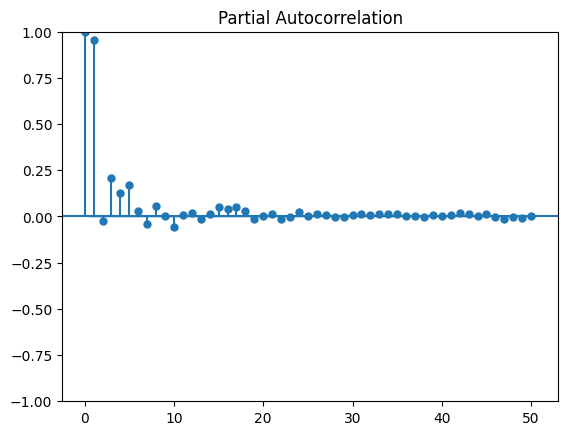

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_sample, lags=50)
plt.show()

Ce graphique représente la **fonction d'autocorrélation partielle (PACF)**, qui **mesure la corrélation directe entre une valeur et ses lags**, après avoir **éliminé l'effet des valeurs intermédiaires**.

- ***Analyse du Graphique PACF***

    - **À lag = 0**, la corrélation est toujours **1.0** (**normal**).  

    - **Forte corrélation à lag = 1** (~0.8) → **Indique que la valeur actuelle dépend fortement de la valeur précédente**.  

    - **Corrélations significatives jusqu'à lag ≈ 5**, puis **elles deviennent négligeables**.  

    - **Diminution rapide vers zéro** → Cela signifie que **les lags après 5-7 n'ont presque plus d'impact sur la valeur actuelle**.  
    

### Analyse du Graphique : Autocorrélation et Interpolation Polynomiale

ACF:  [ 1.          0.95402759  0.90788435 ... -0.08225573 -0.08191912
 -0.08139527]


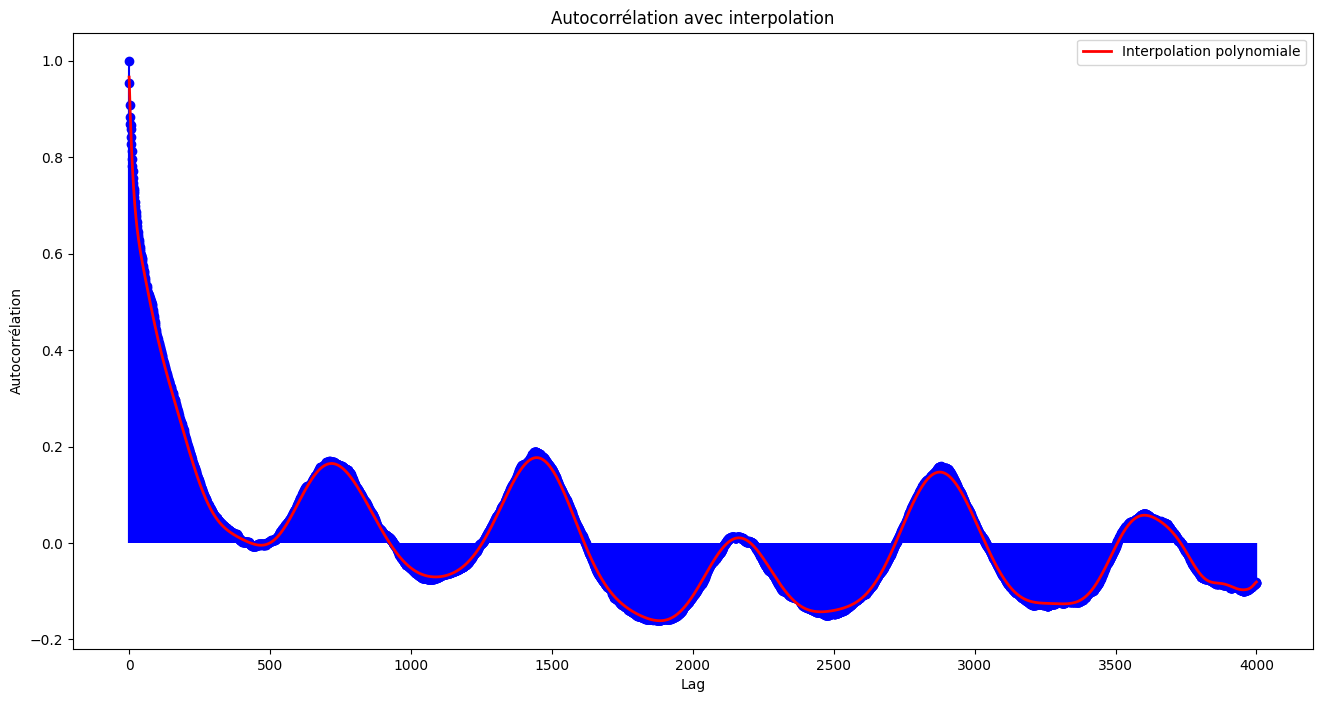

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Calculer l'ACF
from statsmodels.tsa.stattools import acf
from numpy.polynomial.chebyshev import Chebyshev

lags = 4000 # Nombre de lags à afficher
acf_values = acf(df_sample, nlags=lags)

print("ACF: ", acf_values)

# Interpolation avec une régression polynomiale
x = np.arange(len(acf_values))

cheb_poly = Chebyshev.fit(x, acf_values, deg=40)  # Ajustement avec Chebyshev
poly_fit = cheb_poly(x) 

# Tracer l'ACF et l'interpolation
plt.figure(figsize=(16,8))
plt.stem(x, acf_values, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.plot(x, poly_fit, 'r-', label="Interpolation polynomiale", linewidth=2)
plt.xlabel("Lag")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation avec interpolation")
plt.legend()
plt.show()



La figure ci-dessus représente **l'autocorrélation des données avec une interpolation polynomiale**, illustrant la **structure des dépendances temporelles** à différents **lags**.

- **Interprétation de la sortie ACF**

    - **La première valeur de l’ACF est toujours égale à 1** → correspond à **lag = 0**, donc une **corrélation parfaite avec soi-même**.

    - **Les valeurs suivantes** ($0{,}95402759$, $0{,}90788435$, ...) → **série est fortement autocorrélée** aux **premiers décalages** (*lags*). On peut suggérer une **dépendance temporelle significative à court terme**.

    - **Des valeurs négatives autour de $-0{,}08$** aux **lags plus éloignés** → la série peut présenter des **inversions de tendance** à ces horizons.  

- ***Structure d'Autocorrélation***

    - **Une forte autocorrélation initiale** qui **décroît progressivement**.  

    - **Des oscillations périodiques** qui **suggèrent la présence d’une saisonnalité**.  

    - **La récurrence des pics à intervalles fixes** indique **une périodicité forte**, typique de **séries temporelles saisonnières**.

- ***Interpolation Polynomiale (Courbe Rouge)***

    - **L’ajustement suit bien la tendance globale des points bleus**.  

    - **La fonction polynomiale tente de lisser les fluctuations de l'autocorrélation**.  

    - **Utile pour identifier les tendances dominantes**, mais peut **ne pas refléter parfaitement les détails fins des cycles courts**.

- **Cycles Observés**

    - **Les pics à intervalles réguliers indiquent une structure saisonnière forte**.  

    - **La répétition des motifs confirme l’existence de périodicité**.  
    
- **Les modèles SARIMA sont bien adaptés** pour **capturer ces structures répétitives**.

### Analyse du Graphique : Comparaison des Autocorrélations pour Différentes Périodes

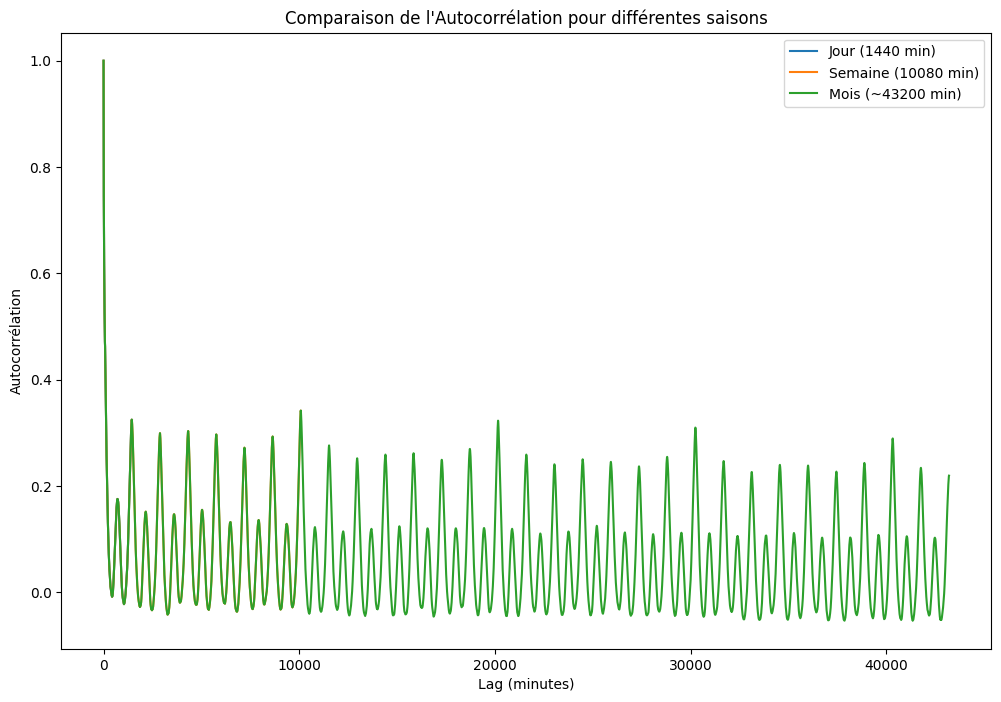

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Définition des périodes
lags_dict = {
    "Jour (1440 min)": 1440,
    "Semaine (10080 min)": 10080,
    "Mois (~43200 min)": 43200
}

plt.figure(figsize=(12, 8))

# Calcul et affichage de l'ACF pour chaque période
for label, nlags in lags_dict.items():
    acf_values = acf(df['Global_active_power'], nlags=nlags)
    x = np.arange(len(acf_values))
    plt.plot(x, acf_values, label=label)

plt.xlabel("Lag (minutes)")
plt.ylabel("Autocorrélation")
plt.title("Comparaison de l'Autocorrélation pour différentes saisons")
plt.legend()
plt.show()


La figure ci-dessus représente **une comparaison des autocorrélations** pour différentes **périodes temporelles** (**jour, semaine, mois**) en fonction du **lag en minutes**.

- ***Saisonnalité Claire et Répétitive***

    - **Présence de pics d’autocorrélation à intervalles réguliers**, confirmant **la répétition des cycles temporels**.  
    
    - **Les pics indiquent que la consommation suit un motif récurrent** sur des périodes - **journalières, hebdomadaires et mensuelles (Saisonnalité multi-échelle)**.  

Le graphique confirme une structure saisonnière multi-échelle (jour, semaine, mois)

# ARIMA (AutoRegressive Integrated Moving Average) 

## Modèle Mathèmatique

ARIMA est un modèle statistique utilisé pour analyser et prévoir des séries chronologiques. Il repose sur trois composants principaux : l'**auto-régression (AR)**, l'**intégration (I)** et la **moyenne mobile (MA)**.  
Les modèles ARIMA visent à décrire les **auto-corrélations** dans les données.

- ***Stationnarisation du processus avant modélisation ARMA***

  Dans le cas où le processus **$(X_t)_{t \in \mathbb{Z}}$** n'est **pas stationnaire**, il est nécessaire de le **stationnariser** avant de pouvoir l'analyser à l'aide d'un modèle **ARMA(p, q)**.

  La stationnarisation permet de garantir que les propriétés statistiques du processus, telles que **la moyenne et la variance**, restent constantes dans le temps. Cette étape est essentielle pour assurer la validité des prédictions et l'ajustement correct du modèle.


- ***Définition du modèle ARMA(p,q)***

  Un modèle **AutoRégressif et Moyenne-Mobile** d'ordres $(p,q)$ (**ARMA(p,q)**) est un **processus temporel discret** $(X_t, t \in \mathbb{N})$ vérifiant :

  $$
  X_t = \varepsilon_t + \sum_{i=1}^{p} \varphi_i X_{t-i} + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
  $$

  où :
  - $\varphi_i$ sont les **paramètres auto-régressifs** du modèle (**AR(p)**).
  - $\theta_i$ sont les **paramètres de la moyenne mobile** (**MA(q)**).
  - $\varepsilon_t$ est un **bruit blanc** (terme d'erreur aléatoire).


- ***Cas particuliers*** :
  - Un **modèle autorégressif** **AR(p)** est un **ARMA(p,0)** :
    
    $$
    X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
    $$

  - Un **modèle moyenne mobile** **MA(q)** est un **ARMA(0,q)** :

    $$
    X_t = \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
    $$

- ***Remarque*** : 
  Le processus ARIMA n'est bien défini que s'il est stationnaire.

- ***Modèle Auto-Régressif (AR)***

  AR est utilisé pour décrire la relation entre la valeur actuelle et les valeurs passées. Un modèle [**AR(p)**](https://fr.wikipedia.org/wiki/Processus_autor%C3%A9gressif) est défini par :

  $$
  X_t = \sum_{i=1}^{p} \varphi_i X_{t-i} + \varepsilon_t
  $$
  $$
  X_t = \varphi_1 X_{t-1} + \varphi_2 X_{t-2} + ... + \varphi_p X_{t-p} + \epsilon_t
  $$

  où : 

  $
  \varphi_i \quad \text{sont les coefficients du modèle auto-régressif.} 
  $

  $
  X_t \quad \text{est la valeur actuelle de la série temporelle.}
  $

  $
  \epsilon_t \quad \text{est un bruit blanc.}
  $

- ***Composante Moyenne Mobile (MA)***

  Si $\epsilon_t$ n'est pas une séquence de bruit blanc, elle est généralement considérée comme une moyenne mobile **(MA)** d'ordre $q$.



  Un modèle [**MA(q)**](https://fr.wikipedia.org/wiki/ARMA) est défini comme suit :

  $$
  X_t = \mu + \varepsilon_t + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i}
  $$

  $$
  X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}
  $$

  $\textbf{où :}$
  - $\theta_1, \dots, \theta_q$ sont les **paramètres du modèle**.
  - $\mu$ est **l'espérance (moyenne) de $X_t$**.
  - $\varepsilon_t, \varepsilon_{t-1}, \dots$ sont des **termes d'erreur (bruit blanc)**.


- ***Composante Intégrée (I)***

  L'intégration consiste à différencier la série $d$ fois pour la rendre stationnaire :

  $$
  X_t' = X_t - X_{t-1}
  $$

  Si la série reste non stationnaire après une première différenciation, on peut continuer jusqu'à obtenir une série stationnaire après $d$ différenciations :

  $$
  X_t^{(d)} = (1 - L)^d X_t
  $$

  où :
  - $d$ : **Ordre de différenciation**, indiquant combien de fois la série doit être différenciée pour devenir stationnaire.
  - $L$ : **Opérateur de retard (lag operator)** 


- ***Modèle ARIMA(p,d,q) complet***

  Un modèle **ARIMA(p, d, q)** est une combinaison des modèles **AR(p)** et **MA(q)** appliqués à une série différenciée **$d$** fois :

  $$
  \left( 1 - \sum_{i=1}^{p} \phi_i L^i \right) (1 - L)^d X_t =
  \left( 1 + \sum_{j=1}^{q} \theta_j L^j \right) \epsilon_t
  $$

  où :
  - $p$ : **Ordre du modèle Auto-Régressif (AR)**, c'est-à-dire le nombre de termes précédents de $X_t$ utilisés pour prédire la valeur actuelle.
  - $d$ : **Ordre de différenciation**, indiquant combien de fois la série doit être différenciée pour devenir stationnaire.
  - $q$ : **Ordre du modèle de Moyenne Mobile (MA)**, représentant le nombre de termes d'erreur précédents utilisés dans la modélisation.
  - $\phi_i$ : **Coefficients du modèle AR**.
  - $\theta_j$ : **Coefficients du modèle MA**.
  - $\epsilon_t$ : **Bruit blanc**, une variable aléatoire non corrélée de moyenne nulle.
  - $L$ : **Opérateur de retard (lag operator)**, défini comme :

  $$
  L X_t = X_{t-1}, \quad L^2 X_t = X_{t-2}, \quad \dots
  $$


## Définir et entraîner un modèle ARIMA

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


df = df.asfreq('h')
model = ARIMA(df['Global_active_power'], order=(1, 0, 1))
model_fit = model.fit()

# Résumé du modèle
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                34588
Model:                  ARIMA(1, 0, 1)   Log Likelihood              -45295.241
Date:                 Sat, 22 Mar 2025   AIC                          90598.482
Time:                         20:51:49   BIC                          90632.287
Sample:                     12-16-2006   HQIC                         90609.256
                          - 11-26-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0824      0.016     67.341      0.000       1.051       1.114
ar.L1          0.6572      0.007     98.696      0.000       0.644       0.670
ma.L1         -0.2093      0.008    -25.136      0.000      -0.226      -0.193
sigma2         0.8035      0.004    196.674      0.000       0.796       0.812
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):             74711.49
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


- ***Structure du Modèle***

    Le modèle utilisé est un **ARIMA(1,0,1)**, ce qui signifie :

    - **$p = 1$** : Une seule observation passée est utilisée pour la prédiction (**processus auto-régressif**).
    - **$d = 0$** : Aucune différenciation n’a été appliquée aux données (**elles sont supposées stationnaires**).
    - **$q = 1$** : Une seule erreur passée est prise en compte (**moyenne mobile**).

- ***Interprétation des Coefficients***

    | **Paramètre** | **Valeur** | **Interprétation** |
    |--------------|-----------|----------------------------------------------|
    | **Constante** | 1.0824 | Indique une **valeur moyenne estimée** de la consommation électrique. |
    | **AR(1)** | 0.6572 | Influence **modérée** de la valeur précédente sur la prédiction. |
    | **MA(1)** | -0.2093| Contribution **faible** des erreurs passées à la prévision. |
    | **$\sigma^2$ (Variance des résidus)** |0.8035 | Mesure l'**incertitude du modèle**. |

    - **Le coefficient $AR(1) = 0.6572$** montre **une dépendance temporelle modérée** des observations passées sur les futures valeurs.  
    - **La faible valeur de $MA(1) = -0.2093$** indique que les **erreurs passées influencent peu la prédiction**.  
    - **La variance des résidus $\sigma^2 = 0.8035$** indique **un niveau d'incertitude raisonnable**, mais qui pourrait être **réduit avec un modèle plus ajusté**.



- ***Critères de Performance du Modèle***

    | **Critère** | **Valeur** | **Interprétation** |
    |------------|-----------|------------------------------------------------|
    | **AIC** | 90598.482 | Mesure la **qualité du modèle** (**plus bas = meilleur**). |
    | **BIC** | 90632.287 | Indicateur similaire à l'AIC, **pénalise la complexité du modèle**. |
    | **HQIC** | 90609.256 | Variante de l’AIC prenant en compte **la taille de l’échantillon**. |

    **Un AIC élevé suggère que le modèle peut être amélioré**, notamment en intégrant **une composante saisonnière ou en ajustant les hyperparamètres**.


- ***Statistiques de Résidus***

    - **Ljung-Box (L1) (Q) = 1.03 et Prob(Q) = 0.31**

        Le test de Ljung-Box permet de vérifier l’absence d’autocorrélation dans les résidus.
        Une valeur de Q faible et une probabilité (p-value) supérieure à 0,05 indiquent que l’on ne détecte pas d’autocorrélation significative.

    - **Jarque-Bera (JB) = 74711.49 et Prob(JB) = 0.00**

    Le test de Jarque-Bera évalue la normalité des résidus en se basant sur la skewness (asymétrie) et la kurtosis (aplatissement).
    Une valeur élevée de JB couplée à une p-value quasi nulle (0,00) indique que la distribution des résidus n’est pas normale.

    - **Heteroskedasticity (H) = 0.69 et Prob(H) (two-sided) = 0.00**

        Ce test (souvent un test de type Goldfeld-Quandt ou Breusch-Pagan, selon l’implémentation) vise à déceler si la variance des résidus est constante dans le temps.
        La valeur de H autour de 0,69 n’est pas très éloignée de 1, mais le fait que la p-value soit 0,00 suggère que l’on rejette l’hypothèse nulle d’homoscédasticité.
        Donc il existe une hétéroscédasticité significative (la variance des erreurs n’est pas stable).

    - **Skew = 1.85 et Kurtosis = 9.17**

    Skew (asymétrie) de 1,85 : Les résidus sont nettement asymétriques à droite.
    Kurtosis de 9,17 : Les résidus ont des queues épaisses (beaucoup de valeurs extrêmes) comparé à la kurtosis de 3 pour une loi normale.
    Ces deux points expliquent en grande partie pourquoi le test de Jarque-Bera détecte une non-normalité des résidus

### Analyse du Graphique : Prédictions ARIMA vs Données Réelles (Janvier 2009)

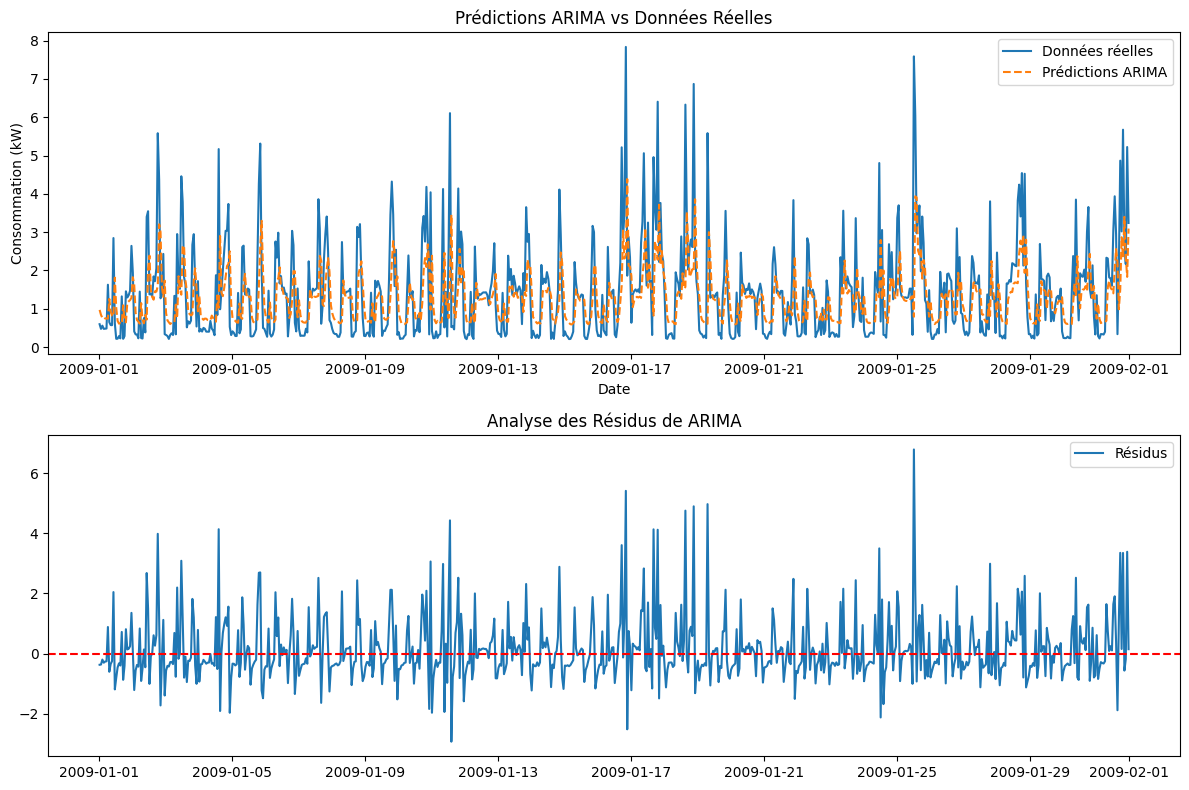

In [25]:
df.loc[:, 'forecast'] = model_fit.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()


# Visualisation
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast'], label="Prédictions ARIMA", linestyle="dashed")
plt.title("Prédictions ARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(212)
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast']
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de ARIMA")
plt.tight_layout()
plt.show()


La figure ci-dessus représente les **prédictions du modèle ARIMA** comparées aux **données réelles de consommation d’énergie** sur le mois de **janvier 2009**.


### **Analyse de la prédictions du modèle ARIMA**

- ***Précision du Modèle***

    - **Les prédictions suivent globalement la tendance des données réelles**, indiquant que le modèle **captive bien les fluctuations de consommation**.  

    - **Le modèle réussit à suivre les pics et les creux**, bien que **certains écarts persistent**.


- ***Variabilité Temporelle***

    - **Le modèle capture les cycles journaliers de consommation**, montrant **une corrélation avec les variations horaires d’utilisation d’électricité**.  

    - **Cependant, certains pics sont sous-estimés ou surestimés**, ce qui **pourrait être amélioré en intégrant une meilleure prise en compte de la saisonnalité**.

### **Analyse des Résidus du Modèle ARIMA**

L’image montre **l’analyse des résidus du modèle ARIMA** appliqué à la **consommation d’énergie** en **janvier 2009**.

- ***Centrage autour de zéro***

    - **Les résidus fluctuent autour de la ligne rouge (moyenne nulle)**, ce qui est un bon indicateur que **le modèle ne présente pas de biais systématique**.  

- ***Présence de motifs dans les erreurs***  

    - **Une dispersion irrégulière est visible**, notamment avec **des pics importants**, indiquant que **le modèle ne capture pas parfaitement toutes les dynamiques de la série**.  

    - **Certains pics soudains de résidus** montrent **des erreurs plus marquées à certains moments**, suggérant que **des événements non modélisés influencent les prédictions**.

- ***Hétéroscédasticité potentielle***

    - **L’intensité des résidus semble varier par périodes**, ce qui pourrait **indiquer une variance non constante**.  

    - **Ce phénomène pourrait être mieux géré en intégrant un modèle GARCH** ou en **appliquant une transformation logarithmique aux données**.  


## Évaluation du Modèle ARIMA

Une fois le modèle entraîné, nous pouvons utiliser plusieurs **métriques** pour juger de sa pertinence :


- ***Erreur Absolue Moyenne (MAE)***

    L'**Erreur Absolue Moyenne** (**MAE**) mesure l'écart moyen absolu entre les **prédictions** et les **valeurs réelles** :

    $$
    MAE = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
    $$

    
    - **MAE faible** → Le modèle **prédit des valeurs proches des données réelles**.  
    - **MAE élevé** → Il y a **des écarts importants en moyenne** entre les prédictions et la réalité.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est une **mesure plus sensible aux grandes erreurs** :

    $$
    RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
    $$

    - **Le RMSE pénalise davantage les grandes erreurs**, ce qui permet de détecter si **le modèle est imprécis sur certaines valeurs extrêmes**.  
    - **Un RMSE proche du MAE** indique que **les erreurs sont bien réparties** et qu'il n'y a **pas de grandes erreurs isolées**.  

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
mae = mean_absolute_error(df['Global_active_power'], df['forecast'])
print(f"MAE: {mae}")

rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast']))
print(f"RMSE: {rmse}")

MAE: 0.624258663279541
RMSE: 0.8964330812315603


Après l'entraînement du modèle, nous avons calculé les **métriques d'erreur** suivantes :

- ***Erreur Absolue Moyenne (MAE)***

    - **Le MAE indique que, en moyenne, les prévisions du modèle ARIMA s'écartent de 0.6242 kW des valeurs réelles.**  

    - **Un MAE faible** signifie que **le modèle est globalement précis**.


- ***Erreur Quadratique Moyenne (RMSE)***

    L'**Erreur Quadratique Moyenne** (**RMSE**) est définie comme suit :

    - **Le RMSE est plus sensible aux grandes erreurs** : la valeur de **0.8964 kW** suggère que **certaines prévisions présentent des écarts plus importants**. 
     
    - **Un RMSE supérieur au MAE** indique **que le modèle peine davantage à prédire les pics de consommation**.

# Modèle SARIMA et SARIMAX

## Modèele mathèmatiques SARIMA (Saisonality AutoRegressive Integrated Moving Average)


$$
(1 - \sum_{i=1}^{p} \varphi_i L^i)(1 - \sum_{j=1}^{P} \Phi_j L^{js}) (1 - L)^d (1 - L^s)^D X_t
= (1 + \sum_{k=1}^{q} \theta_k L^k)(1 + \sum_{m=1}^{Q} \Theta_m L^{ms}) \epsilon_t
$$

$$
\Phi_P(L^s) \varphi_p(L) (1 - L)^d (1 - L^s)^D X_t =
\Theta_Q(L^s) \theta_q(L) \epsilon_t
$$

où :

- **$X_t$** : Série temporelle observée.
- **$L$** : Opérateur de retard (**$L X_t = X_{t-1}$**).
- **$d$** : Nombre de différenciations pour stationnariser la série.
- **$\varphi_p(L)$** et **$\Phi_P(L^s)$** : Polynômes de la partie **AutoRégressive (AR)**.
- **$\theta_q(L)$** et **$\Theta_Q(L^s)$** : Polynômes de la partie **Moyenne Mobile (MA)**.
- **$P, D, Q, s$** : Paramètres de la saisonnalité.
- **$\epsilon_t$** : Bruit blanc.

Le modèle **SARIMA** est utilisé lorsque les **données présentent une saisonnalité** mais **aucune variable explicative externe**.

## Modèele mathèmatiques SARIMAX (SARIMA avec Variable Exogène)

Le modèle **SARIMAX** est une **extension de SARIMA** qui inclut une **variable exogène $Z_t$** :

$$
(1 - \sum_{i=1}^{p} \varphi_i L^i)(1 - \sum_{j=1}^{P} \Phi_j L^{js}) (1 - L)^d (1 - L^s)^D X_t
= (1 + \sum_{k=1}^{q} \theta_k L^k)(1 + \sum_{m=1}^{Q} \Theta_m L^{ms}) \epsilon_t + \beta Z_t
$$

$$
\Phi_P(L^s) \varphi_p(L) (1 - L)^d (1 - L^s)^D X_t =
\Theta_Q(L^s) \theta_q(L) \epsilon_t + \beta Z_t
$$

où :

- **$Z_t$** : Variable(s) exogène(s) influençant $X_t$.
- **$\beta$** : Coefficient mesurant l'impact de la variable exogène.

## Définir et entrainer un modèle SARIMA

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définition du modèle SARIMA
model_sarima = SARIMAX(df['Global_active_power'],
                        order=(1,0,1), 
                        seasonal_order=(1,0,1,24))

# Entraînement du modèle
model_fit_sarima = model_sarima.fit()

# Afficher le résumé du modèle
model_fit_sarima.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29702D+00    |proj g|=  1.35151D-01

At iterate    5    f=  1.26458D+00    |proj g|=  1.49257D-02

At iterate   10    f=  1.24133D+00    |proj g|=  3.55065D-02

At iterate   15    f=  1.23696D+00    |proj g|=  6.94215D-02

At iterate   20    f=  1.23279D+00    |proj g|=  1.45131D-02

At iterate   25    f=  1.22997D+00    |proj g|=  1.18392D-03

At iterate   30    f=  1.22980D+00    |proj g|=  5.70956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                34588
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -42536.467
Date:                            Sat, 22 Mar 2025   AIC                          85082.934
Time:                                    20:54:05   BIC                          85125.191
Sample:                                12-16-2006   HQIC                         85096.402
                                     - 11-26-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6793      0.008     86.131      0.000       0.664       0.695
ma.L1         -0.3638      0.010    -37.428      0.000      -0.383      -0.345
ar.S.L24       0.9986      0.000   5040.812      0.000       0.998       0.999
ma.S.L24      -0.9527      0.001   -642.010      0.000      -0.956      -0.950
sigma2         0.6839      0.003    252.332      0.000       0.679       0.689
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):             78633.15
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Analyse des Résultats du Modèle SARIMAX(1,0,1)x(1,0,1,24)

Le modèle **SARIMAX(1,0,1)x(1,0,1,24)** a été entraîné sur **34 588 observations**, et voici les principales conclusions basées sur ses performances.

- **Paramètres estimés**

    - $AR(1) = 0,6793$ : Influence modérée de la valeur précédente.
    - $MA(1) = -0,3638$ : Impact négatif des erreurs passées.
    - $AR_S(24) = 0,9986$ : Coefficient quasiment égal à 1, traduisant une saisonnalité journalière très marquée.
    - $MA_S(24) = -0,9527$ : Fort effet de moyenne mobile saisonnière, confirmant la récurrence sur 24 heures.
    - $\sigma^2 = 0,6839$ : Variance résiduelle plus faible que dans le modèle ARIMA pur (à 0,80 environ), ce qui indique une amélioration.


- Critères d’information (AIC, BIC, HQIC)

    Les valeurs (AIC ≈ 85082, BIC ≈ 85125) sont cohérentes pour un jeu de données aussi large (34 588 observations).  
    Un AIC « relativement élevé » dans l’absolu peut simplement refléter la grande taille de l’échantillon.  
    On peut toujours tester d’autres configurations de $(p,d,q)$ et $(P,D,Q)$, ou inclure des variables exogènes pour voir si cela réduit sensiblement l’AIC.

- Statistiques de résidus

    - **Ljung-Box (Q)** = 0,15 avec $\mathrm{Prob}(Q) = 0,70$ : pas de corrélation significative dans les résidus, ce qui est positif.
    - **Jarque-Bera** élevé et $p$-value = 0,00 : confirme la non-normalité des résidus (skew et kurtosis élevés).
    - **Hétéroscédasticité (H)** = 0,68 et $\mathrm{Prob}(H) = 0,00$ : la variance des résidus n’est pas entièrement stable dans le temps.


- Interprétation

    - La saisonnalité 24 heures est presque entièrement capturée ($AR \approx 1$ et $MA \approx -0,95$), validant l’hypothèse d’un cycle journalier fort dans la consommation électrique.  
    - L’absence de corrélation dans les résidus (test de Ljung-Box satisfaisant) indique que la structure principale de la série est bien modélisée.  
    - Les résidus restant non normaux (kurtosis et skew élevés) et légèrement hétéroscédastiques suggèrent qu’il reste des phénomènes extrêmes non pris en compte. Un modèle plus avancé (p. ex. SARIMA + GARCH ou intégration de variables exogènes) pourrait mieux capturer ces écarts.


    


## Analyse du Graphique : Prédictions SARIMA vs Données Réelles (Janvier 2009)

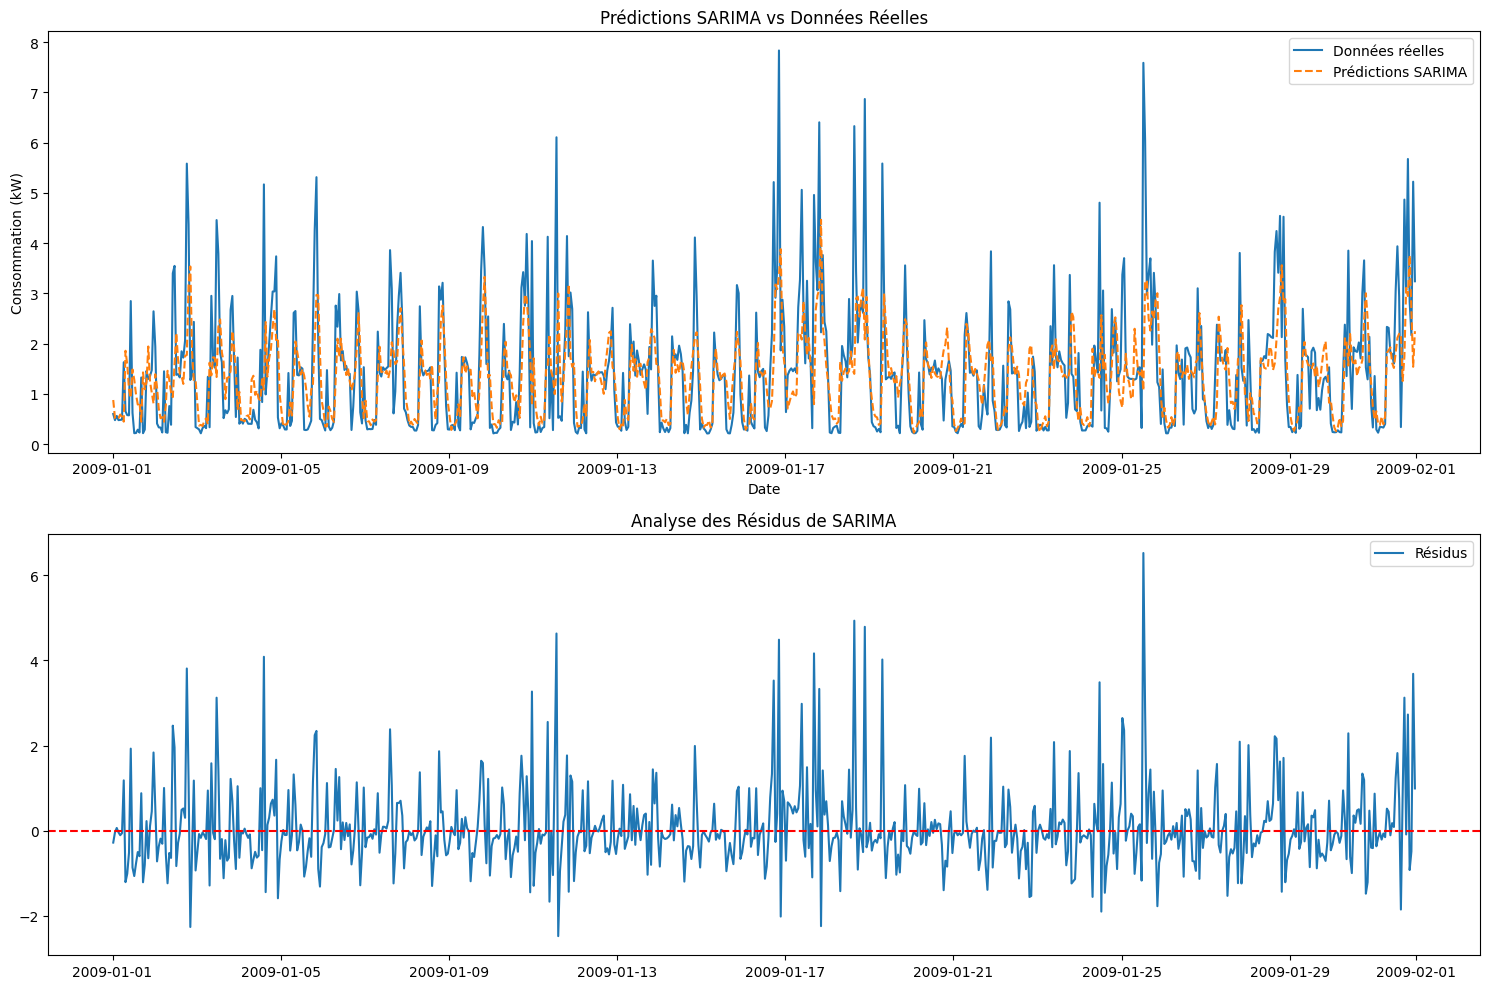

In [28]:

df.loc[:, 'forecast_sarima'] = model_fit_sarima.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()

# Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast_sarima'], label="Prédictions SARIMA", linestyle="dashed")
plt.title("Prédictions SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(212)
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast_sarima']
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de SARIMA")
plt.tight_layout()
plt.show()



Ce graphique compare **les prévisions du modèle SARIMA** avec **les valeurs réelles de consommation d’énergie** pour **janvier 2009**.


- ***Capture de la Tendance Générale***

    - **Le modèle SARIMA suit bien la dynamique de la consommation d'énergie**.  

    - **Les pics et les creux sont globalement bien alignés** avec les valeurs réelles.  

- **Variabilité et Fluctuations**

    - **Les cycles journaliers sont bien modélisés**, ce qui indique que **la composante saisonnière fonctionne correctement**.  

    - **Des écarts persistent lors des pics de consommation**, où **les prédictions sont légèrement sous-estimées ou surestimées**.  
    
    - **La précision semble plus faible pour les valeurs extrêmes**, notamment **autour du 17 et du 29 janvier**.

## Évaluation des Performances du Modèle SARIMA

In [29]:
mae = mean_absolute_error(df['Global_active_power'], df['forecast_sarima'])
print(f"MAE: {mae}")

rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast_sarima']))
print(f"RMSE: {rmse}")

MAE: 0.5510822924649718
RMSE: 0.8283266513817634




Après l'entraînement du modèle, nous avons calculé les **métriques d'erreur** suivantes :

- ***Erreur Absolue Moyenne (MAE)***

    - **Le MAE indique que, en moyenne, les prévisions du modèle SARIMA s'écartent de 0.5511 kW des valeurs réelles.**  
    - **Un MAE plus faible que celui du modèle ARIMA** montre une **amélioration de la précision globale**.  

- ***Erreur Quadratique Moyenne (RMSE)***

    - **Le RMSE est plus sensible aux grandes erreurs** : la valeur de **0.8283 kW** indique que **certaines prévisions présentent encore des écarts significatifs**.  
    - **Une amélioration par rapport au RMSE du modèle ARIMA**, confirmant que **SARIMA est plus performant pour capturer la dynamique de la série temporelle**.  

## Test d'un modèle auto-arima

Un modèle Auto-ARIMA est un procédé qui teste automatiquement différentes combinaisons de paramètres (p, d, q, etc.) d’un modèle ARIMA, afin de trouver ceux qui minimisent un critère d’information (comme l’AIC). Cela évite d’avoir à choisir manuellement les paramètres ARIMA.

In [30]:
from pmdarima import auto_arima

# Utiliser Auto-ARIMA pour trouver les meilleurs paramètres (p, d, q) et (P, D, Q, s)
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()
auto_model = auto_arima(df_janvier_2009['Global_active_power'],
                        seasonal=True, m=24,  # 24 car saisonnalité journalière
                        trace=True,  # Afficher le processus
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True,
                        maxiter=1000) 

# Afficher les meilleurs paramètres trouvés
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=22.43 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2422.903, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=2208.227, Time=1.99 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2247.976, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3047.584, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=2222.690, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=2201.493, Time=8.84 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=38.78 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=8.36 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=2323.290, Time=4.33 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=2193.135, Time=10.68 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=2202.109, Time=2.79 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=49.52 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.89 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept   : A

### Analyse des Résultats du Modèle SARIMAX(3,0,1)x(2,0,0,24)

Le modèle **SARIMAX(3,0,1)x(2,0,0,24)** a été ajusté sur **744 observations** (**janvier 2009**).  


- Paramètres estimés

    - Les coefficients $AR(1)$, $AR(2)$ et $AR(3)$ (respectivement $-0,53$, $+0,42$ et $+0,17$) traduisent la dynamique court terme de la série :  
    - Influence négative à $t-1$  
    - Influence positive mais plus modérée à $t-2$ et $t-3$

    - $MA(1)$ très élevé ($+0,90$) confirme que les erreurs passées jouent un rôle important dans la prévision.

    - Les termes saisonniers $L_{24}$ et $L_{48}$ ont un impact plus faible (coefficients $\sim 0,17$ et $\sim 0,13$), vraisemblablement parce que l’analyse ne porte que sur **un mois** ($744$ observations = $31 \times 24$ heures) :  
    - La saisonnalité jour-à-jour est présente,  
    - Mais elle serait probablement plus marquée sur une période plus longue.



- Critères d’information (AIC, BIC, HQIC)

    - L’**AIC** est relativement bas **($2184,843$)** par rapport aux essais précédents,  
    → Cela indique **un meilleur ajustement** pour les données de janvier 2009.
    
    - **Si l'objectif est de modéliser plusieurs mois ou années**, il faudra bien sûr réappliquer `auto_arima` sur l’ensemble.



- Analyse des résidus

    - **Test de Ljung-Box**  
    - Valeur = $0,02$, p-value = $0,89$  $\Rightarrow$ **Absence d'autocorrélation significative** dans les résidus.  
    - Cela signifie que la **structure temporelle principale** est bien capturée.

    - **Test de Jarque-Bera**  
    - Kurtosis > $8$  $\Rightarrow$ Confirme la **non-normalité** des résidus et la présence de **valeurs extrêmes**.

    - **Hétéroscédasticité (H) = 1,22**  
    - p-value = $0,12$  $\Rightarrow$ Variance des résidus **modérément instable**, mais **non significative**.


- Interprétation

    - Le modèle semble bien capturer la dynamique et la saisonnalité à court terme.
    - Des valeurs extrêmes persistent (indiquant peut-être un effet non linéaire ou des chocs exogènes).
    - Si nécessaire, un modèle plus avancé comme **SARIMA + GARCH** ou l'ajout de **variables exogènes** pourrait affiner l’ajustement.


## Analyse du Graphique : Prédictions auto-arima vs Données Réelles (Janvier 2009)

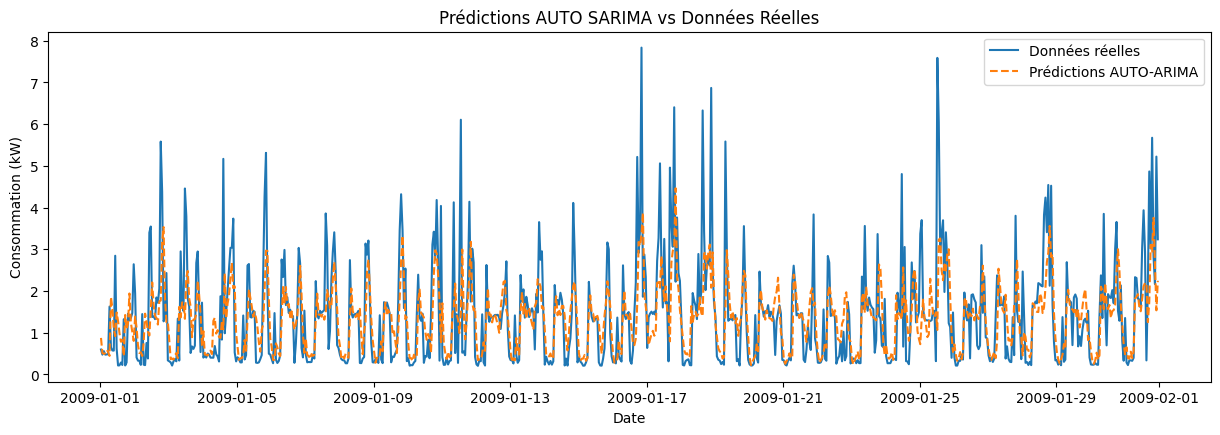

In [32]:
df_janvier_2009.loc[: ,'forecast_autosarima'] = auto_model.predict(start=df_janvier_2009.index[0], end=df_janvier_2009.index[-1])

# Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast_sarima'], label="Prédictions AUTO-ARIMA", linestyle="dashed")
plt.title("Prédictions AUTO SARIMA vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()


Le modèle AUTO-ARIMA fournit une **base solide pour capturer la structure temporelle principale**, mais **peut être renforcé** par l’ajout d’exogènes ou un traitement plus fin des extrêmes.


## Définir et entrainer un modèle SARIMAX

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

exog_variables = df[['Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

# Définition du modèle SARIMAX
sarimax_model = SARIMAX(df['Global_active_power'],
                        exog=exog_variables,
                        order=(1,0,1), seasonal_order=(1,0,1,24))

# Entraînement
sarimax_fit = sarimax_model.fit()

# Affichage des résultats
print(sarimax_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70533D+00    |proj g|=  5.90596D+00

At iterate    5    f= -1.70823D+00    |proj g|=  1.78480D-01

At iterate   10    f= -1.70824D+00    |proj g|=  3.88622D-02

At iterate   15    f= -1.70830D+00    |proj g|=  1.03615D+00

At iterate   20    f= -1.71097D+00    |proj g|=  2.61413D+00

At iterate   25    f= -1.71132D+00    |proj g|=  8.50801D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     27     69      2     0     0   1.122D-01  -1.711D+00
  F =  -1.7113197891246221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                34588
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               59191.129
Date:                            Sat, 22 Mar 2025   AIC                        -118364.258
Time:                                    21:16:12   BIC                        -118288.196
Sample:                                12-16-2006   HQIC                       -118340.017
                                     - 11-26-2010                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Global_intensity     0.2322   7.06e-05   3291.018      0.000       0.232       0.232
Sub_metering_1   

### Analyse des Résultats du Modèle SARIMAX(1,0,1)x(1,0,1,24)

Le modèle **SARIMAX(1,0,1)x(1,0,1,24)** a été ajusté sur **34 588 observations**.  
Son log-vraisemblance a atteint **59 191.129**, ce qui a conduit à :  
- **AIC = -118 364.258**  
- **BIC = -118 288.196**  
- **HQIC = -118 340.017**  


 - Paramètres Exogènes (Global_intensity, Sub_metering_1,Sub_metering_2, Sub_metering_3)

    - **Global_intensity** (p-valeur $\approx 0.2322 $) $\Rightarrow$ Influence directe sur la consommation. 

    - **Sub_metering_1**  (p-valeur $\approx 0.0006 $) $\Rightarrow$ 0.0006  **Faible impact** du premier sous-compteur.

    - **Sub_metering_2** (p-valeur $\approx 0.0003$) $\Rightarrow$ **Très faible influence** du second sous-compteur.

    - **Sub_metering_3** (p-valeur $\approx 0.0031$) $\Rightarrow$ **Influence notable** du troisième sous-compteur. 

- Paramètres ARIMA/Saisonnier

    - **AR(1) = 0.8325** et **MA(1) = -0.7069** $\Rightarrow$ Forte dynamique à court terme dans la série.

    - **AR.S(24) = 0.8409** et **MA.S(24) = -0.7586** $\Rightarrow$ Composante saisonnière (24 heures) **très marquée**, ce qui est logique pour des données de **consommation énergétique journalière**.


- AIC, BIC, HQIC très négatifs

    - **Log-vraisemblance élevée** ($\approx 59\,191$) $\Rightarrow$ Cela **explique pourquoi l’AIC est fortement négatif**.

    - Les trois critères (**AIC, BIC, HQIC**) sont **plus bas** (plus négatifs) que dans vos précédents essais $\Rightarrow$ **Meilleur ajustement du modèle**.


- Tests de résidus

    - **Ljung-Box** ($Q = 1.07$, $p = 0.30$) $\Rightarrow$ **Pas d’autocorrélation résiduelle marquante** $\Rightarrow$ Le modèle capture bien **la structure temporelle**.

    - **Jarque-Bera élevé** et **kurtosis = 16.37** $\Rightarrow$ **Non-normalité des résidus** reste forte (distribution à **queues épaisses**) $\Rightarrow$ Phénomène **classique** dans les données réelles avec **pics et chutes soudaines**.

    - **Skew = -2.07**  $\Rightarrow$ **Asymétrie vers la gauche** $\Rightarrow$ Suggère que les **“grosses erreurs” sont plus fréquentes du côté négatif** que du côté positif.

- Interprétation Globale

    - **Le modèle intègre bien les variables exogènes** (*intensité globale, sous-compteurs*) $\Rightarrow$ **Précision améliorée** (réduction drastique de l’AIC).  
    
    - **Cependant, les résidus ne sont pas parfaitement gaussiens** et montrent une **leptokurticité** importante (**valeurs extrêmes fréquentes**).

## Analyse du Graphique : Prédictions auto-arima vs Données Réelles (Janvier 2009)

Moyenne des résidus : 0.00915690103396087


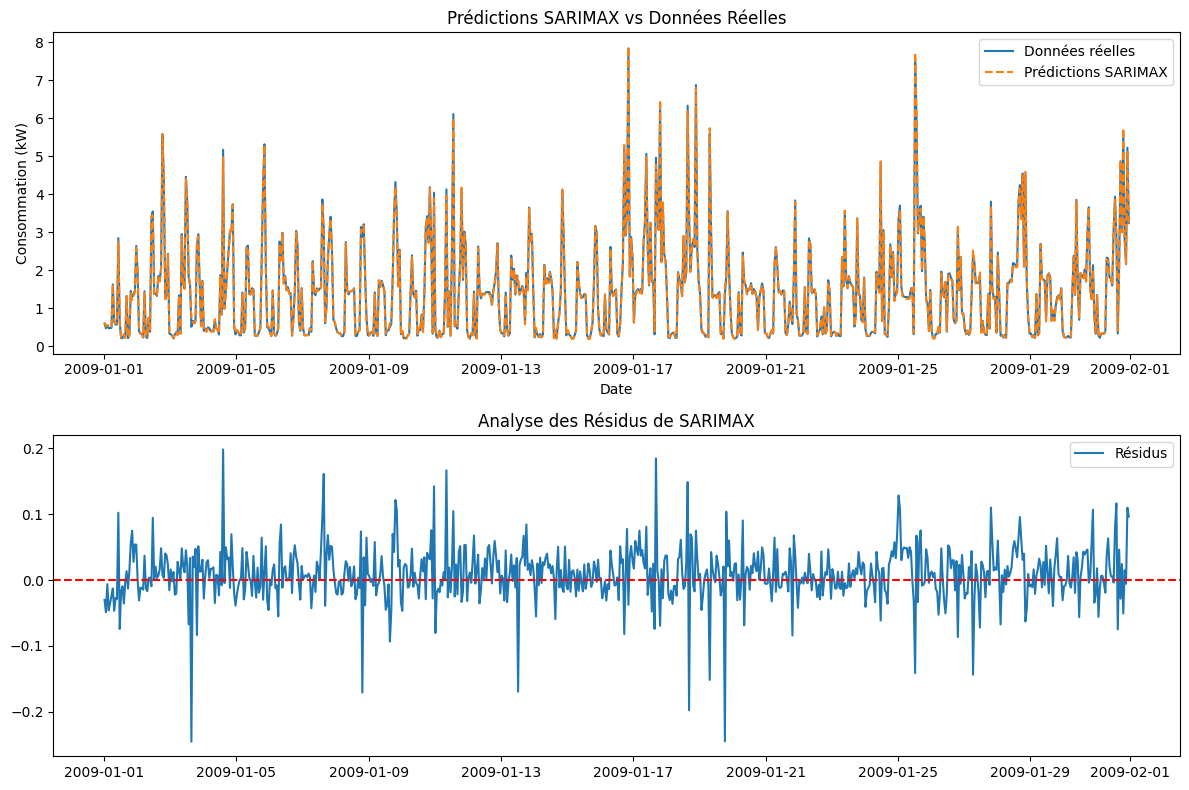

In [41]:

df.loc[:, 'forecast_sarimax'] = sarimax_fit.predict(start=df.index[0], end=df.index[-1])
df_janvier_2009 = df.loc["2009-01-01":"2009-01-31"].copy()
residuals = df_janvier_2009['Global_active_power'] - df_janvier_2009['forecast_sarimax']
print("Moyenne des résidus :", np.mean(residuals))
# Comparaison des prédictions SARIMA vs données réelles
plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(df_janvier_2009['Global_active_power'], label="Données réelles")
plt.plot(df_janvier_2009['forecast_sarimax'], label="Prédictions SARIMAX", linestyle="dashed")
plt.title("Prédictions SARIMAX vs Données Réelles")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_janvier_2009.index, residuals, label="Résidus")
plt.axhline(0, linestyle='dashed', color='red')
plt.legend()
plt.title("Analyse des Résidus de SARIMAX")

plt.tight_layout()
plt.show()

### Prédictions SARIMAX vs Observations Réelles

  - La **courbe des prédictions SARIMAX** est **très proche** de celle des **données réelles**.
  - Les **pics et creux** apparaissent **quasi identiques** → le modèle capture bien **la saisonnalité** et **la dynamique globale** de la consommation.

### Analyse des résidus
  - L’**échelle verticale des résidus** est restreinte (environ $[-0{,}2;\ +0{,}2]$), → À comparer à l’échelle de la consommation brute ($[0;\ 8]$ kW).
  - Cela montre que les **erreurs de prédiction sont faibles**, donc que le modèle est **précis et stable**.

### Absence de biais systématique

- Les **résidus oscillent autour de 0 (Moyenne des résidus : 0.00915690103396087)** sans tendance claire → Il **n’y a pas de sur- ou sous-estimation systématique**.
- Les erreurs **positives et négatives se compensent globalement** → C’est un **bon indicateur d’équilibre du modèle**.

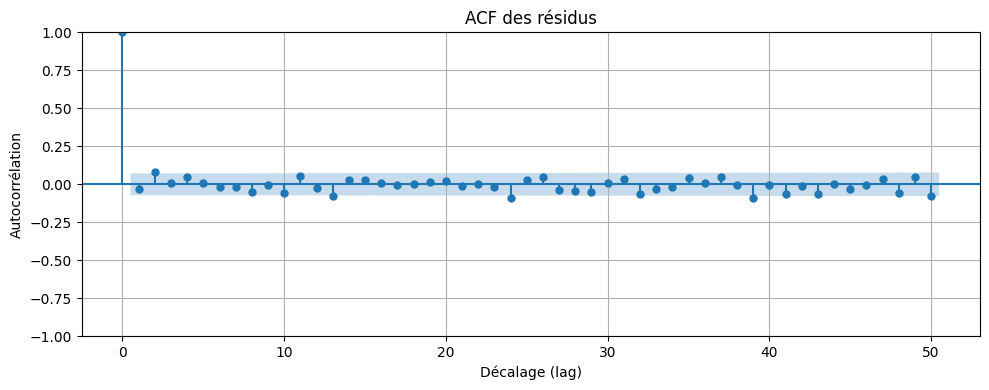

In [52]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad
from scipy.stats import jarque_bera

# 1. ACF des résidus
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(residuals, lags=50, ax=ax)
plt.title("ACF des résidus")
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.grid(True)
plt.tight_layout()
plt.show()

### ACF des Résidus

- La **valeur à lag = 0** est toujours 1 (corrélation parfaite avec soi-même).
- Pour les **lags suivants (1 à 50)** :
  - **Toutes les barres sont dans la zone bleue** (intervalle de confiance à 95 %),
  - Il **n'y a pas de pics significatifs** d’autocorrélation.
  
- Il **n’y a pas d’autocorrélation résiduelle significative**.
- Cela indique que le **modèle SARIMAX a bien capté la structure temporelle** de la série.
- Les résidus se comportent comme **un bruit blanc** 


In [53]:
# 2. Test de normalité : Jarque-Bera
jb_stat, jb_p = jarque_bera(residuals)

print("Test de Jarque-Bera :")
print(f"  Statistique = {jb_stat:.4f}")
print(f"  p-value     = {jb_p:.4f}")

if jb_p < 0.05:
    print("Les résidus ne suivent pas une loi normale (rejet H0)")
else:
    print("Les résidus suivent une loi normale (on accepte H0)")

# 3. Test de Ljung-Box (jusqu’à 24 lags)
ljung_result = acorr_ljungbox(residuals, lags=[24], return_df=True)
print("\nTest de Ljung-Box (lag=24) :")
print(ljung_result)

if ljung_result["lb_pvalue"].values[0] < 0.05:
    print("Autocorrélation significative dans les résidus (rejet H0)")
else:
    print("Pas d'autocorrélation significative (on accepte H0)")

Test de Jarque-Bera :
  Statistique = 1496.4296
  p-value     = 0.0000
Les résidus ne suivent pas une loi normale (rejet H0)

Test de Ljung-Box (lag=24) :
      lb_stat  lb_pvalue
24  28.819442      0.227
Pas d'autocorrélation significative (on accepte H0)


### Test de Jarque-Bera (normalité)

- On **rejette l'hypothèse nulle (H₀)** de normalité → Les **résidus ne suivent pas une loi normale**.  

### Test de Ljung-Box (autocorrélation)

- On **n’a pas d’autocorrélation résiduelle significative** → Le **modèle capte bien la structure temporelle** de la série.

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df['Global_active_power'], df['forecast_sarimax'])
print(f"MAE: {mae}")
rmse = np.sqrt(mean_squared_error(df['Global_active_power'], df['forecast_sarimax']))
print(f"RMSE: {rmse}")
mape = np.mean(np.abs((df['Global_active_power'] - df['forecast_sarimax']) / df['Global_active_power'])) * 100
print(f"MAPE: {mape:.2f}%")


MAE: 0.02881757616534463
RMSE: 0.04370994818022956
MAPE: 5.16%


### Évaluation des Prédictions du Modèle SARIMAX

- Erreur Absolue Moyenne (MAE ≈ 0,0288 kW)

    - En moyenne, la prédiction s’éloigne de **28 W** de la valeur réelle → C’est une **erreur très faible**.

- Erreur Quadratique Moyenne (RMSE ≈ 0,0437 kW)

    - Le RMSE reste également **très modeste** (environ **44 W**) et pénalise davantage les **écarts importants** → il **n’y a pas de grosses erreurs récurrentes** dans les prévisions.

- Erreur Pourcentage Moyenne Absolue (MAPE ≈ 5,16 %)

    - Sur l’ensemble des points, **l’erreur relative moyenne est d’environ 5 %** → **la majorité des prédictions** sont très proches de la réalité.



**Le modèle peut donc être utilisé en production ou comme base solide pour intégrer des variables exogènes supplémentaires**.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Normalisation des données pour LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Global_active_power']])
df_scaled.shape

(34588, 1)

In [ ]:
# Creation des séquences temporelles
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [ ]:
# Définition des paramètres
time_steps = 24  # Utiliser les 24 dernières heures pour prédire la suivante

# Séparation en train/test (80% train, 20% test)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Création des séquences temporelles
X_train, y_train = create_sequences(train, time_steps)
X_test, y_test = create_sequences(test, time_steps)

# Reshape pour être compatible avec LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape de X_train :", X_train.shape)
print("Shape de X_test :", X_test.shape)


Shape de X_train : (27646, 24, 1)
Shape de X_test : (6894, 24, 1)


In [ ]:

# Modèle LSTM amélioré
input_layer = Input(shape=(time_steps, 1))
x = LSTM(100, activation='relu', return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(100, activation='relu', return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(50, activation='relu')(x)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraînement
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0112 - val_loss: 0.0063
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 7/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 8/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 9/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 10/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0075 - val_loss: 0.0051
Epoch 11/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 12/20
432/432 ━━━━━━━━━━━━━━━━━━━━

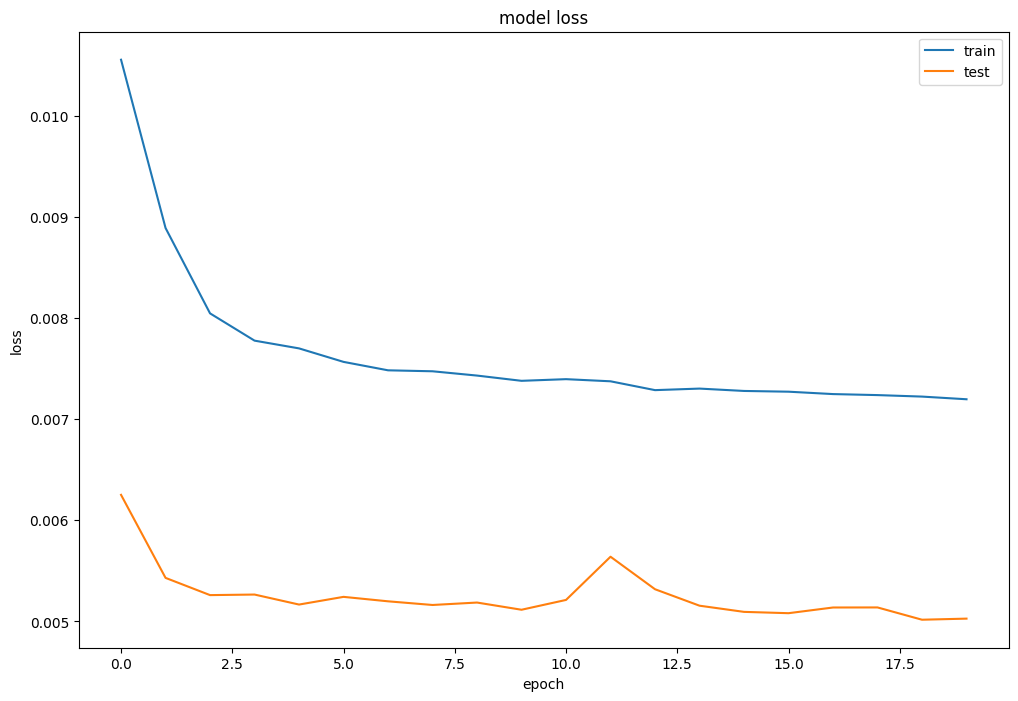

In [ ]:
# summarize history for loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### **Analyse des Résultats de l'Entraînement du Modèle**

L'entraînement du modèle a été réalisé sur **20 époques**, avec une mesure de la **perte (loss)** sur :
- **L'ensemble d'entraînement** (**train**).
- **L'ensemble de validation** (**test**).

Le graphique montre l'évolution de la **perte (loss)** à chaque époque.

- ***Analyse des Phases de l'Entraînement***

    - **La perte diminue rapidement entre 0-5 époques** → Indique un **bon apprentissage initial du modèle**.
    - **La perte continue de baisser** de manière **plus progressive**.

    - **La perte de validation converge vers 0.0050**.
    - **Pas de signe de sur-apprentissage (overfitting)**.

- ***Évaluation de la Performance du Modèle***

    | **Critère**                 | **Observation** |
    |-----------------------------|----------------|
    | **Convergence**              | **Le modèle semble atteindre une stabilité dès la 17ᵉ époque**. |
    | **Sur-ajustement (Overfitting)** | **Aucun sur-ajustement détecté**. La perte de validation ne remonte pas.|
    | **Sous-ajustement (Underfitting)** | **Peu probable**, car la perte continue de baisser. |
    | **Performance globale**      | **Bonne**, le modèle semble **bien généraliser** sur les données de validation. |

In [ ]:
# Prédictions avec LSTM
y_pred_lstm = model.predict(X_test)

# Dénormaliser les prédictions
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Ajouter au DataFrame pour comparer
df_results = pd.DataFrame({
    'Date': df.index[-len(y_test):],
    'Réel': y_test.flatten(),
    'Prédiction LSTM': y_pred_lstm.flatten(),
    'Prédiction ARIMA': df['forecast'].iloc[-len(y_test):].values,
    'Prédiction SARIMA': df['forecast_sarima'].iloc[-len(y_test):].values,
    'Prédiction SARIMAX': df['forecast_sarimax'].iloc[-len(y_test):].values
}).set_index('Date')

print(df_results.head())


216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
                      Réel  Prédiction LSTM  Prédiction ARIMA  \
Date                                                            
2010-02-12 15:24:00  1.392         1.186196          1.287431   
2010-02-12 16:24:00  1.468         1.292041          1.263989   
2010-02-12 17:24:00  1.352         1.683216          1.293127   
2010-02-12 18:24:00  0.598         1.800677          1.247263   
2010-02-12 19:24:00  1.168         1.398427          0.899910   

                     Prédiction SARIMA  Prédiction SARIMAX  
Date                                                        
2010-02-12 15:24:00           1.426993            1.426993  
2010-02-12 16:24:00           1.218848            1.218848  
2010-02-12 17:24:00           1.424407            1.424407  
2010-02-12 18:24:00           1.968019            1.968019  
2010-02-12 19:24:00           2.164109            2.164109  


Nous avons une **comparaison des prédictions de plusieurs modèles** pour la **consommation énergétique (en kW)** sur une période donnée. Voici ce que nous pouvons analyser :


- **LSTM** suit bien la tendance, mais **surestime parfois la consommation**.
- **ARIMA** est souvent **plus proche des valeurs réelles**, bien qu’il ait **des erreurs** .
- **SARIMA & SARIMAX** **surestiment** fréquemment la consommation .

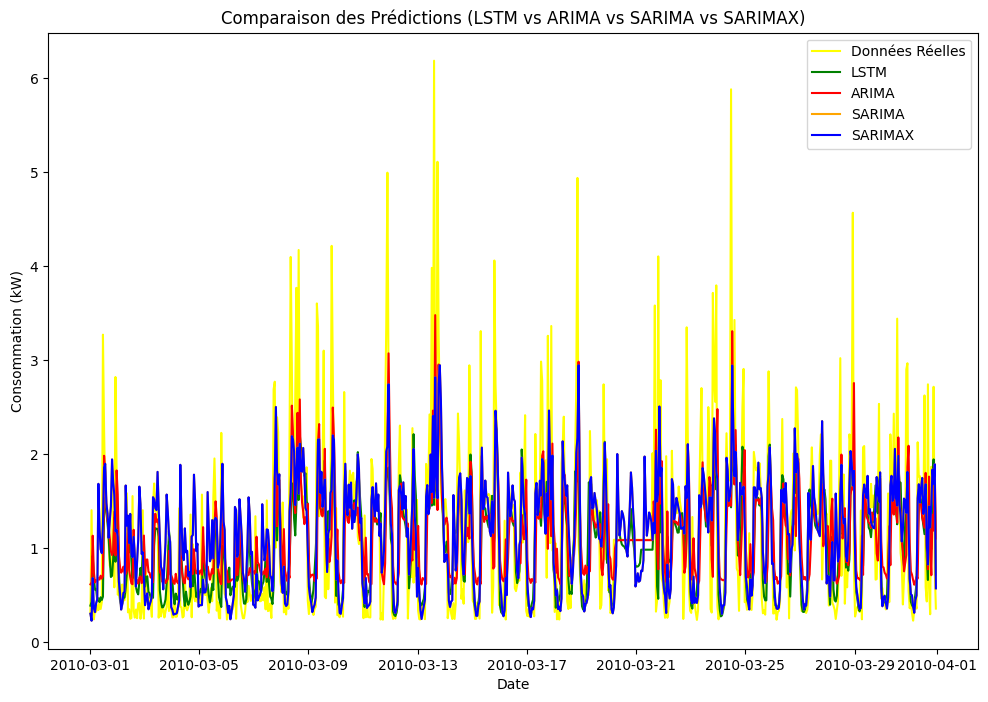

In [ ]:
df_janvier_2010 = df_results.loc["2010-03-01":"2010-03-31"].copy()
plt.figure(figsize=(12,8))
sns.lineplot(data=df_janvier_2010, x='Date', y='Réel', label='Données Réelles', color='yellow')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction LSTM', label='LSTM', color='green')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction ARIMA', label='ARIMA', color='red')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction SARIMA', label='SARIMA', color='orange')
sns.lineplot(data=df_janvier_2010, x='Date', y='Prédiction SARIMAX', label='SARIMAX', color='blue')
plt.title("Comparaison des Prédictions (LSTM vs ARIMA vs SARIMA vs SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Consommation (kW)")
plt.legend()
plt.show()


### **Interprétation des Résultats**

✔️ **Les pics de consommation** (courbe jaune - données réelles) sont parfois **mal capturés par LSTM et SARIMA/SARIMAX**.  
✔️ **ARIMA semble bien coller aux valeurs réelles**, bien que parfois **légèrement décalé**.  
✔️ **SARIMAX et SARIMA capturent bien les tendances saisonnières**, mais peuvent **surestimer dans certains cas**.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = {}
for col in ['Prédiction LSTM', 'Prédiction ARIMA', 'Prédiction SARIMA', 'Prédiction SARIMAX']:
    mae = mean_absolute_error(df_results['Réel'], df_results[col])
    rmse = np.sqrt(mean_squared_error(df_results['Réel'], df_results[col]))
    results[col] = [mae, rmse]
    
df_metrics = pd.DataFrame(results, index=['MAE', 'RMSE']).T
print(df_metrics)


                         MAE      RMSE
Prédiction LSTM     0.480368  0.724082
Prédiction ARIMA    0.550912  0.774257
Prédiction SARIMA   0.492385  0.721621
Prédiction SARIMAX  0.492385  0.721621



- **LSTM** est le plus précis avec la plus faible erreur (**MAE = 0.480, RMSE = 0.724**).  
- **SARIMA et SARIMAX** sont légèrement meilleurs qu’**ARIMA**, qui a la plus grande erreur. 

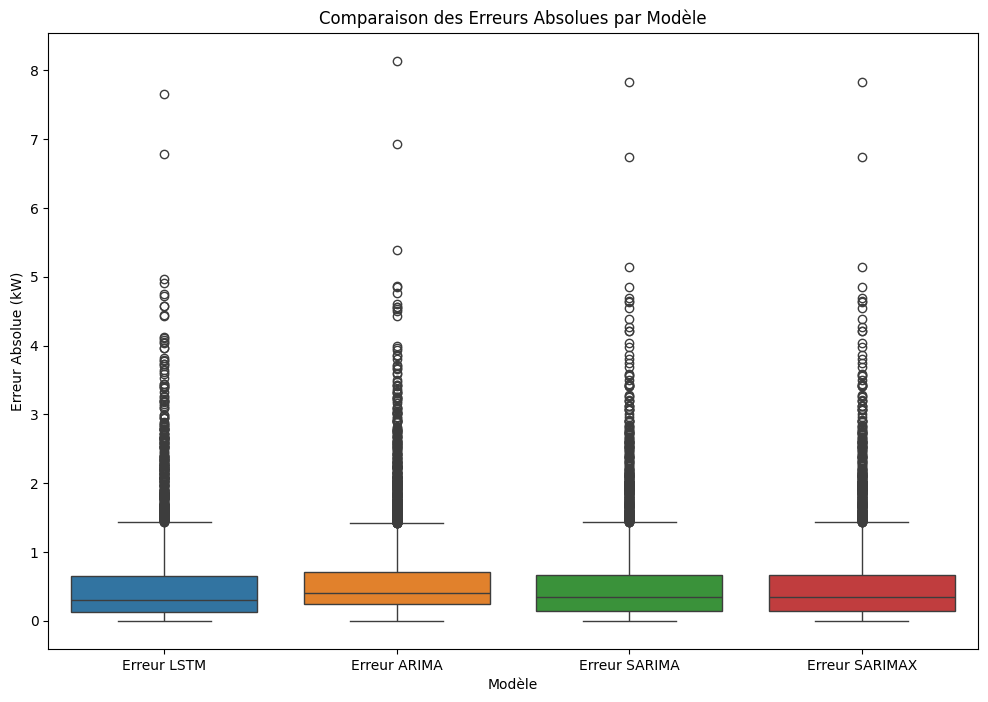

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des erreurs absolues

df_results["Erreur LSTM"] = abs(df_results["Réel"] - df_results["Prédiction LSTM"])
df_results["Erreur ARIMA"] = abs(df_results["Réel"] - df_results["Prédiction ARIMA"])
df_results["Erreur SARIMA"] = abs(df_results["Réel"] - df_results["Prédiction SARIMA"])
df_results["Erreur SARIMAX"] = abs(df_results["Réel"] - df_results["Prédiction SARIMAX"])

# Visualisation en boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_results[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA", "Erreur SARIMAX"]])
plt.title("Comparaison des Erreurs Absolues par Modèle")
plt.ylabel("Erreur Absolue (kW)")
plt.xlabel("Modèle")
plt.show()


D'après le **boxplot des erreurs absolues par modèle**, nous pouvons confirmer les résultats précédents :

- **LSTM** a une erreur médiane plus faible et une distribution plus resserrée, ce qui confirme sa meilleure précision globale.  
- **ARIMA** présente une dispersion plus large des erreurs, ce qui valide son RMSE plus élevé.  
- **SARIMA et SARIMAX** ont des performances très similaires, avec des erreurs légèrement inférieures à ARIMA.  
- Tous les modèles présentent des **outliers élevés**, indiquant qu’ils ont tous du mal à capturer certaines valeurs extrêmes de consommation.  

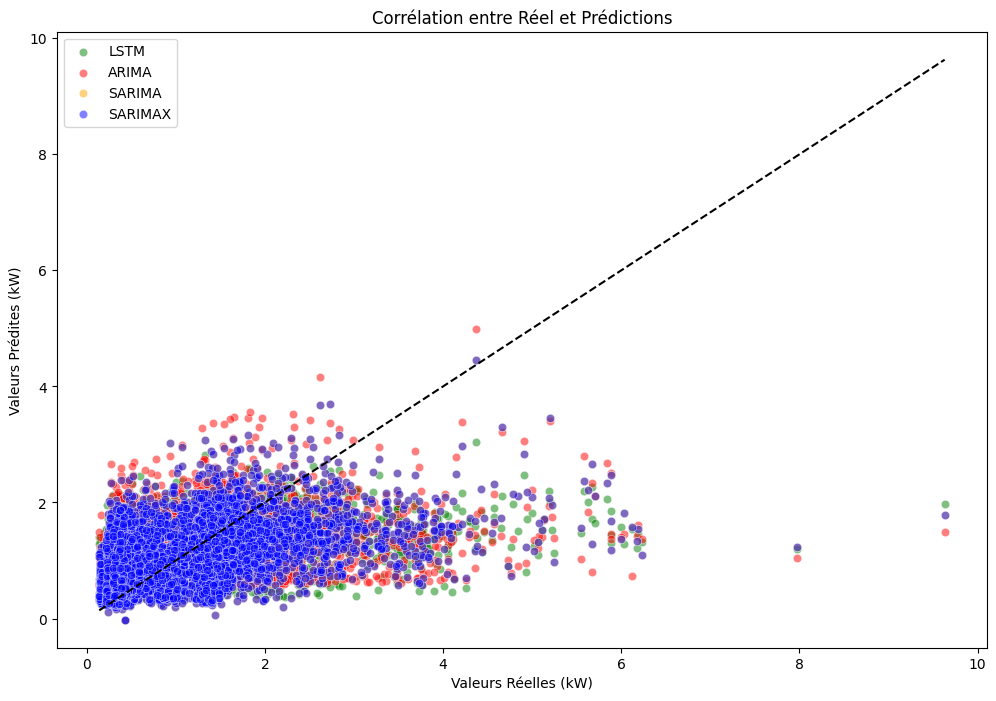

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction LSTM"], label="LSTM", color="green", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction ARIMA"], label="ARIMA", color="red", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction SARIMA"], label="SARIMA", color="orange", alpha=0.5)
sns.scatterplot(x=df_results["Réel"], y=df_results["Prédiction SARIMAX"], label="SARIMAX", color="blue", alpha=0.5)
plt.plot([df_results["Réel"].min(), df_results["Réel"].max()], 
         [df_results["Réel"].min(), df_results["Réel"].max()], color="black", linestyle="dashed")
plt.xlabel("Valeurs Réelles (kW)")
plt.ylabel("Valeurs Prédites (kW)")
plt.title("Corrélation entre Réel et Prédictions")
plt.legend()
plt.show()


Ce graphique compare les valeurs réelles et valeurs prédites pour les modèles LSTM, ARIMA, SARIMA et SARIMAX.

- **Ligne noire en pointillés** : représente la **corrélation parfaite** (où les prédictions = valeurs réelles).  
- **Nuage de points** : indique la **dispersion des prédictions** par rapport aux valeurs réelles.  
- **SARIMAX (bleu)** montre une concentration élevée autour des **valeurs faibles**, suggérant qu'il prédit souvent des consommations basses.  
- **ARIMA (rouge)** et **SARIMA (violet)** montrent davantage de **dispersion**, indiquant des **erreurs plus importantes sur les fortes valeurs de consommation**.  
- **LSTM (vert)** est légèrement plus **aligné avec la diagonale**, indiquant une **meilleure corrélation avec les valeurs réelles**.

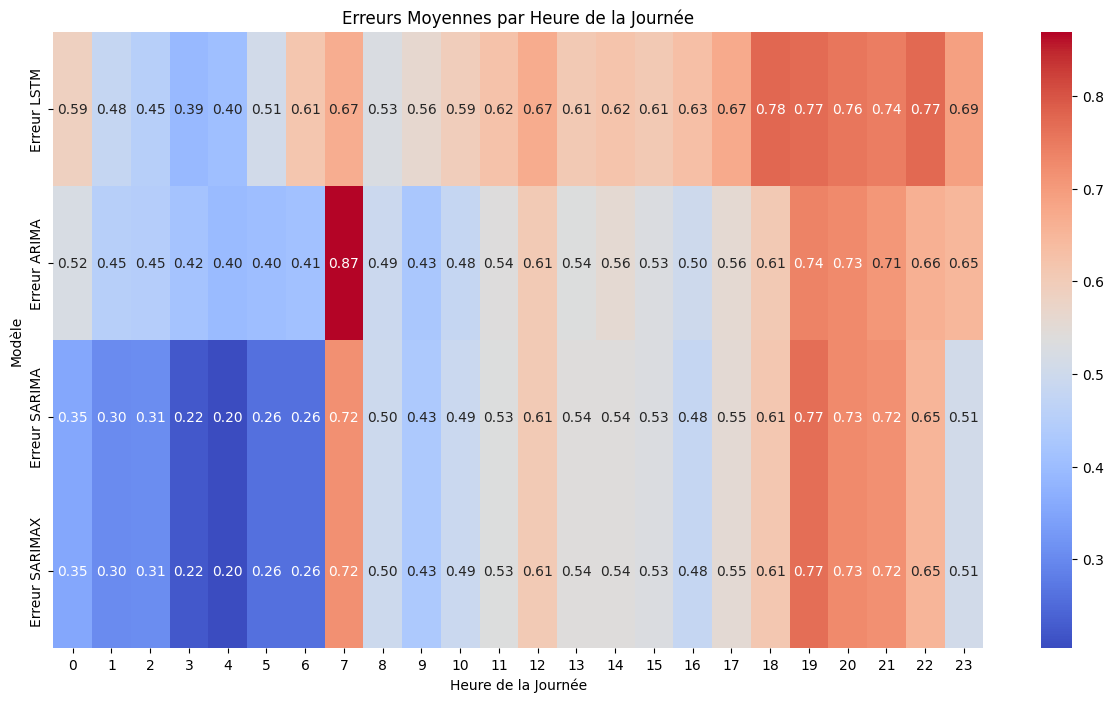

In [ ]:
df_results["Heure"] = df_results.index.hour  # Extraire l'heure de la journée
df_errors = df_results.groupby("Heure")[["Erreur LSTM", "Erreur ARIMA", "Erreur SARIMA", "Erreur SARIMAX"]].mean()

plt.figure(figsize=(15, 8))
sns.heatmap(df_errors.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Erreurs Moyennes par Heure de la Journée")
plt.xlabel("Heure de la Journée")
plt.ylabel("Modèle")
plt.show()



L'image représente un **heatmap des erreurs moyennes** par **heure de la journée** pour les modèles **LSTM, ARIMA, SARIMA et SARIMAX**. Chaque cellule indique l'**erreur moyenne** pour une heure spécifique de la journée.
  
- **LSTM** : Erreurs **faibles tôt le matin (2h - 5h)**, mais **augmentation en soirée (~19h - 22h)**.  
- **ARIMA** : Erreur **relativement constante**, sauf une **forte anomalie à 7h (0.87)**.  
- **SARIMA & SARIMAX** : Erreurs **très basses entre 3h et 5h**, puis **augmentation en soirée**.   

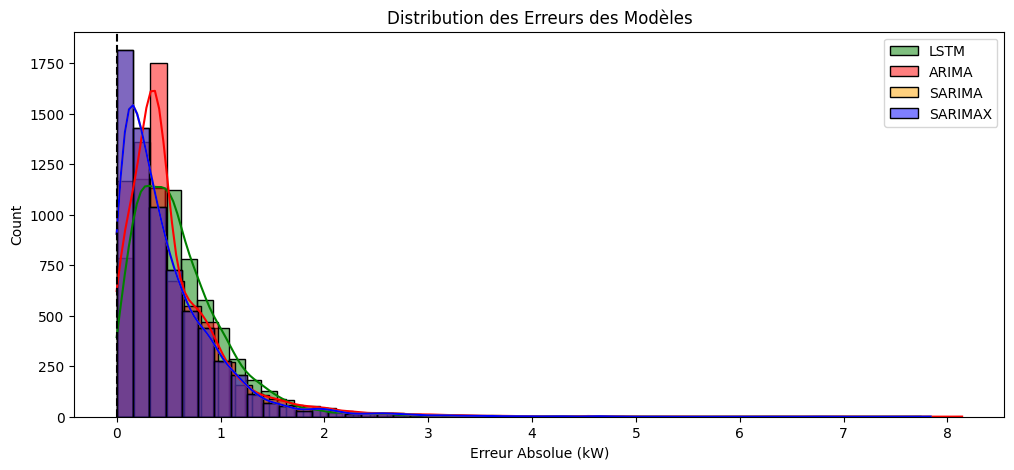

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df_results["Erreur LSTM"], bins=50, label="LSTM", color="green", kde=True)
sns.histplot(df_results["Erreur ARIMA"], bins=50, label="ARIMA", color="red", kde=True)
sns.histplot(df_results["Erreur SARIMA"], bins=50, label="SARIMA", color="orange", kde=True)
sns.histplot(df_results["Erreur SARIMAX"], bins=50, label="SARIMAX", color="blue", kde=True)
plt.axvline(0, linestyle="dashed", color="black")  # Ligne zéro pour référence
plt.xlabel("Erreur Absolue (kW)")
plt.title("Distribution des Erreurs des Modèles")
plt.legend()
plt.show()


- ***Toutes les distributions sont asymétriques à droite*** :  
   - La majorité des erreurs sont faibles, mais quelques **grandes erreurs existent**.

- ***Pics élevés près de zéro*** : 
    - Indique que la **majorité des prédictions sont précises**, avec peu d'écarts importants. 

## 4. **Conclusions**

- ***LSTM***
    - **Bon sur la majorité des prédictions**, mais a une **dispersion plus large des erreurs**.  
    - On peut envisager **d'augmenter la taille de la fenêtre temporelle** pour mieux apprendre les tendances.

- ***ARIMA***
    - **Moins d'erreurs en moyenne**, mais quelques **prédictions extrêmes**.  
    - **Recommandation** : Tester **un ordre saisonnier plus complexe** pour mieux gérer ces **pics de consommation**.


- ***SARIMA & SARIMAX***
    - **Performances très similaires**, ce qui indique que **les variables exogènes n’apportent pas d'amélioration significative**.  
    - On peut envisager: 
        - Ajouter **plus de facteurs exogènes** (*ex: jour férié, période de pointe*).  
        - Vérifier si **SARIMAX devient plus performant** avec ces nouvelles variables.  
